In [2]:
import numpy as np
import os
from pathlib import Path
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image




In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [4]:
torch.__version__

'1.12.1+cu113'

## Setup do algoritmo de Treino e Visualizador de desempenho

In [5]:
#====================================================================
#Algoritmo de Treino
#No pytorch o treino é organizado pelo programador, em um paradigma um
#pouco mais 'mão na masssa'

def train_model(model, criterion, optimizer,NetFile, num_epochs=3):
    loss_curve = {'train': [], 'validation':[]}
    acc_curve = {'train': [], 'validation': []}
    
    bestvalepoch=-1    
    
    #Iteração através de épocas
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        #Iterando na fase de treino e validacão.
        for phase in ['train', 'validation']:
            #switch que habilita a atualização de pesos do modelo
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            batch_count=0
            #iterando pelos batchs do dataloader
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device=device)
                labels = labels.to(device)

                outputs = model(inputs)
                #calcula a perda pelo critério dado
                loss = criterion(outputs, labels)

                if phase == 'train':
                    #zera os gradientes do modelo
                    optimizer.zero_grad()
                    #atualiza os gradientes de acordo com o criterio de perda
                    loss.backward()
                    #itera o otimizador nos pesos, de acordo com a perda
                    optimizer.step()
                
                _, predicted = torch.max(outputs.data, 1)     
                running_corrects += torch.sum(predicted == labels.data)
                running_loss += loss.data
                
            #registra perda e acurácia no treino e na validação, para plotar depois
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_accuracy = running_corrects.float() / len(image_datasets[phase])
            acc_curve[phase].append(epoch_accuracy)
            loss_curve[phase].append(epoch_loss)
            
            print(f'{phase} loss: {epoch_loss:.4f}, accuracy: {epoch_accuracy:.4f}')
        
        if acc_curve['validation'][-1] == max(acc_curve['validation']):
            torch.save(model.state_dict(), NetFile)
            bestvalepoch=epoch
            
        if acc_curve['train'][-1] >= 0.98:
            if epoch - bestvalepoch > 3:
                print('Early Stopping')
                print('Overfit to the train data | No improvement on the validation data')
                break
        print(' ')
                   
    
    return model, loss_curve, acc_curve


def ExperimentRun(df_results):
    figure, axis = plt.subplots(2, 2)
    figure.set_figwidth(14)
    figure.set_figheight(7)
    
    maxtrainacc=0.0
    maxvalacc=0.0
    
    bestnets={}
    

    for index, row in df_results.iterrows():
        lossc=row['loss_curve']
        accc=row['acc_curve']
        lrate='lr'+"{:.0e}".format(row['lrate'])
        objecto=row['objecto']

        losstrain=np.array([float(x) for x in lossc['train']])
        lossval=np.array([float(x) for x in lossc['validation']])
        
        
        acctrain=np.array([float(x) for x in accc['train']])
        accval=np.array([float(x) for x in accc['validation']])
        
        netmaxvalacc=np.max(accval)
        netmaxvalaccepc=np.argmax(accval)
        netmaxtrainacc=np.max(acctrain)
        netmaxtrainaccepc=np.argmax(acctrain)
        
        if netmaxtrainacc > maxtrainacc:
            maxtrainacc=netmaxtrainacc
            bestnets['best_train_net']=row['NetFile']
            bestnets['best_train_net_epc']=netmaxtrainaccepc
            
        if netmaxvalacc > maxvalacc:
            maxvalacc = netmaxvalacc
            bestnets['best_val_net']=row['NetFile']
            bestnets['best_val_net_epc']=netmaxvalaccepc
            
        

        X=np.array([float(x) for x in [*range(len(acctrain))]])

        axis[0, 0].plot(X,acctrain, label =objecto)
        axis[0, 0].set_ylim([0, 1.1])
        axis[0, 0].set_title("Train Accuracy")
        

        axis[0, 1].plot(X,losstrain, label =objecto)
        axis[0, 1].set_title("Train Loss")
        

        axis[1, 0].plot(X,accval, label =objecto)
        axis[1, 0].set_ylim([0, 1.1])
        axis[1, 0].set_title("Validation Accuracy")
        

        axis[1, 1].plot(X,lossval, label =objecto)
        axis[1, 1].set_title("Validation Loss")
        
        
    axis[0, 0].grid()
    axis[0, 1].grid()
    axis[1, 0].grid()
    axis[1, 1].grid()
    bestnets['best_train']=maxtrainacc
    bestnets['best_val']=maxvalacc
    
    return figure, bestnets

def npy_loader(path):
    sample=np.load(path)
    sample=sample.astype('float32')
    sample[:,:,0]=sample[:,:,0]*(1/255)
    sample[:,:,1]=sample[:,:,1]*(1/255)
    sample[:,:,2]=sample[:,:,2]*(1/255)
    sample[:,:,3]=sample[:,:,3]*(1/1024)
    sample=np.moveaxis(sample, 2, 0)
    sample = torch.from_numpy(sample)
    return sample

#normalize espalha os dados ao redor, mas aqui ele está desabilitado
normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                              std=[1.0, 1.0, 1.0, 1.0])

#data transforms incluem as futuras 'data augumentations' que serão usadas
#são utilizados para compor o handler de datasets
model_transform=transforms.Compose([normalize])

def TestModel(model_trained,images_and_states,val_list,key_list,name):
    print('testing on',images_and_states,'dataset')
    #Set the model to eval mode
    model_trained.eval()

    XY_keys=pd.read_json(images_and_states)

    predClassList=[]

    for x in range(XY_keys.shape[0]):
        test=XY_keys.iloc[x]
        impath=test['file']

        torch_image=torch.stack([model_transform(npy_loader(impath)).to(device=device,dtype=torch.float)])

        output = model_trained(torch_image)

        np_output = F.softmax(output, dim=1).cpu().data.numpy()

        position = val_list.index(np.argmax(np_output[0]))
        predClassList.append(int(key_list[position]))

        if x%100==0:
            done=x/XY_keys.shape[0]
            print(f'{done:.1%}',end='|')
    print("")

    XY_keys_and_result=XY_keys.copy()
    XY_keys_and_result['PredY']=predClassList

    accuracy=accuracy_score(XY_keys_and_result['Y'],XY_keys_and_result['PredY'])
    MAPE=mean_absolute_percentage_error(XY_keys_and_result['Y'], XY_keys_and_result['PredY'])
    print("Precisão:",accuracy)
    print('Erro Percentual Médio Absoluto:',f'{MAPE:.1%}')

    plt.rcParams['figure.figsize'] = [20, 20]
    plt.figure() 
    cm_1 = ConfusionMatrixDisplay.from_predictions(y_true=XY_keys_and_result['Y'], y_pred=XY_keys_and_result['PredY'],colorbar=False)
    plt.show()
    plt.rcParams['figure.figsize'] = [16, 9]   
    
    

## Loader de npys e primeira rede utilizada

In [5]:

class MiniLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 51)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


#net = MiniNet()

## Primeiro Experimento
Usamos a rede disponivel em [um tutorial do pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) direcionado a treinar em cima do dataset CIFAR10, que tem a mesmo numero de pixels que nossas amostras, mas com apenas 3 camadas. Essa rede é uma LeNet5 simplificada

In [11]:
#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [12]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='MiniNets0'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    if iteritem['objecto']=='circle':
        folders0=['circleNN/train','circleNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNN/train','trapezoidNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNN/train','half_circleNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNN/train','c_sectorNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
    model=MiniLeNet().to(device)

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

#salvamos esse dataframe
df_results.to_pickle('MiniNets0/MiniNets0.pkl')

Epoch 1/200
----------
train loss: 0.1131, accuracy: 0.0471
validation loss: 0.0939, accuracy: 0.0847
 
Epoch 2/200
----------
train loss: 0.0865, accuracy: 0.1235
validation loss: 0.0826, accuracy: 0.1286
 
Epoch 3/200
----------
train loss: 0.0767, accuracy: 0.1737
validation loss: 0.0722, accuracy: 0.1827
 
Epoch 4/200
----------
train loss: 0.0693, accuracy: 0.1980
validation loss: 0.0692, accuracy: 0.2275
 
Epoch 5/200
----------
train loss: 0.0655, accuracy: 0.2306
validation loss: 0.0631, accuracy: 0.2557
 
Epoch 6/200
----------
train loss: 0.0623, accuracy: 0.2545
validation loss: 0.0615, accuracy: 0.2580
 
Epoch 7/200
----------
train loss: 0.0585, accuracy: 0.2671
validation loss: 0.0584, accuracy: 0.3090
 
Epoch 8/200
----------
train loss: 0.0557, accuracy: 0.3055
validation loss: 0.0577, accuracy: 0.2918
 
Epoch 9/200
----------
train loss: 0.0533, accuracy: 0.3192
validation loss: 0.0556, accuracy: 0.3192
 
Epoch 10/200
----------
train loss: 0.0523, accuracy: 0.3243
val

{'best_train_net': 'MiniNets0/51class_lr1e-03_circle.h5', 'best_train_net_epc': 192, 'best_val_net': 'MiniNets0/51class_lr1e-03_circle.h5', 'best_val_net_epc': 184, 'best_train': 0.972156822681427, 'best_val': 0.7411764860153198}


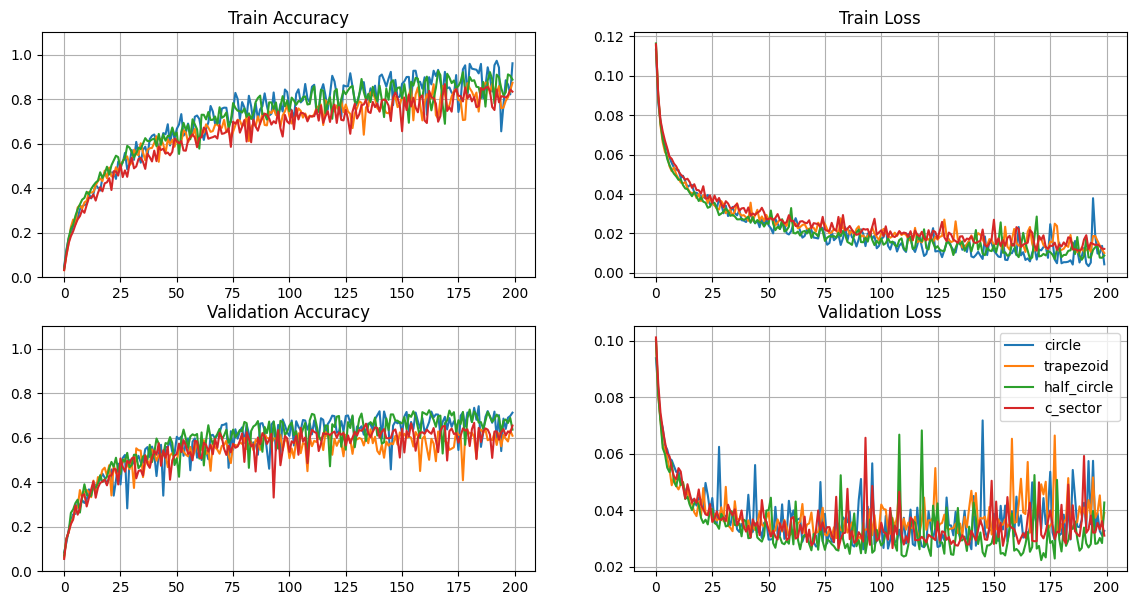

In [13]:
#Plotando os resultados importantes do treino dos modelos

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

testing on circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.7360482654600302
Erro Percentual Médio Absoluto: 1.4%


<Figure size 2000x2000 with 0 Axes>

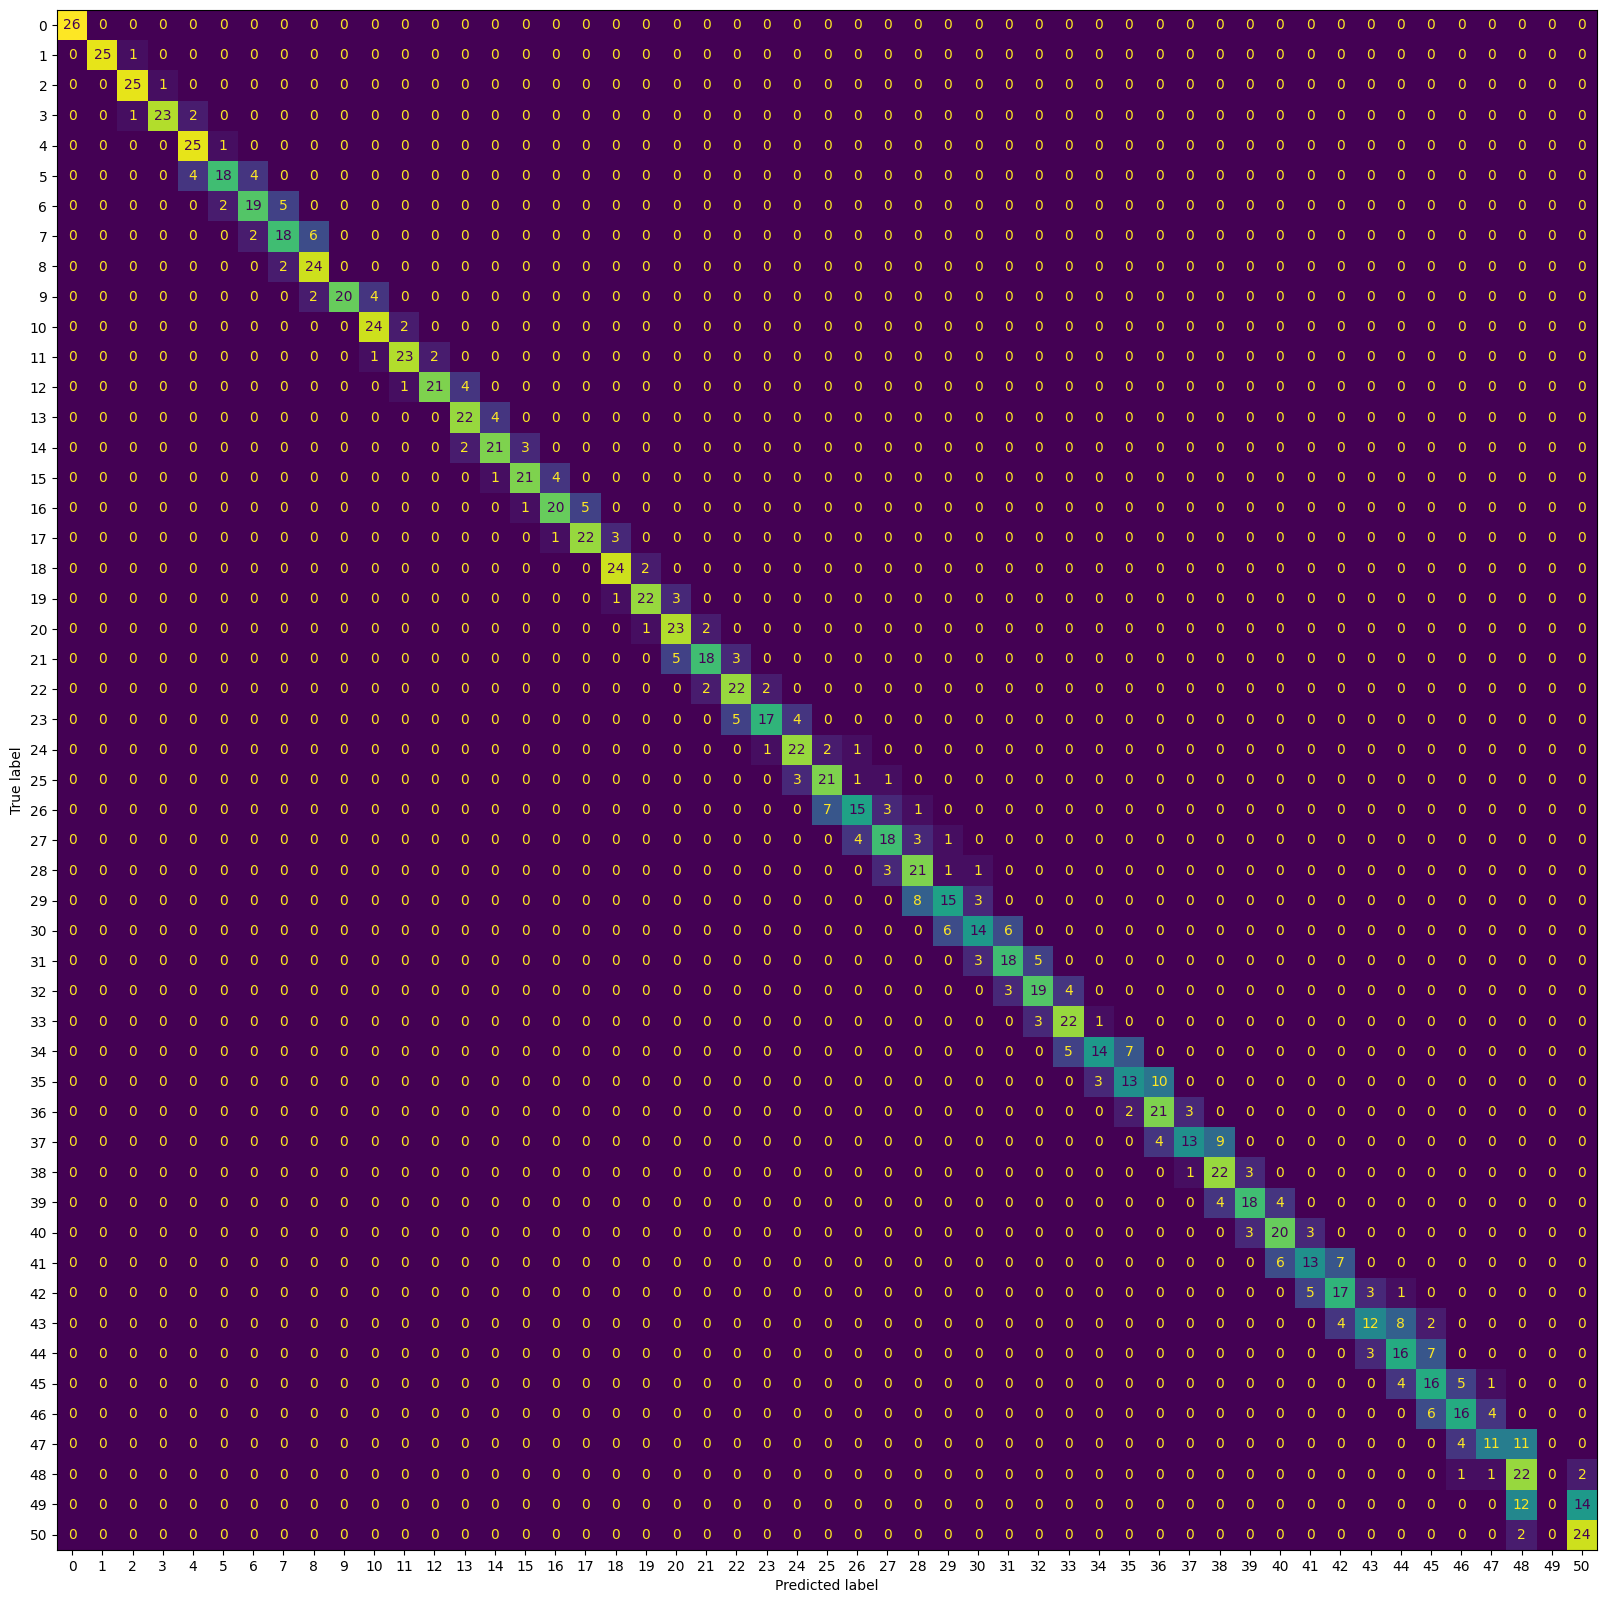

testing on trapezoidNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.6251885369532428
Erro Percentual Médio Absoluto: 1.7%


<Figure size 2000x2000 with 0 Axes>

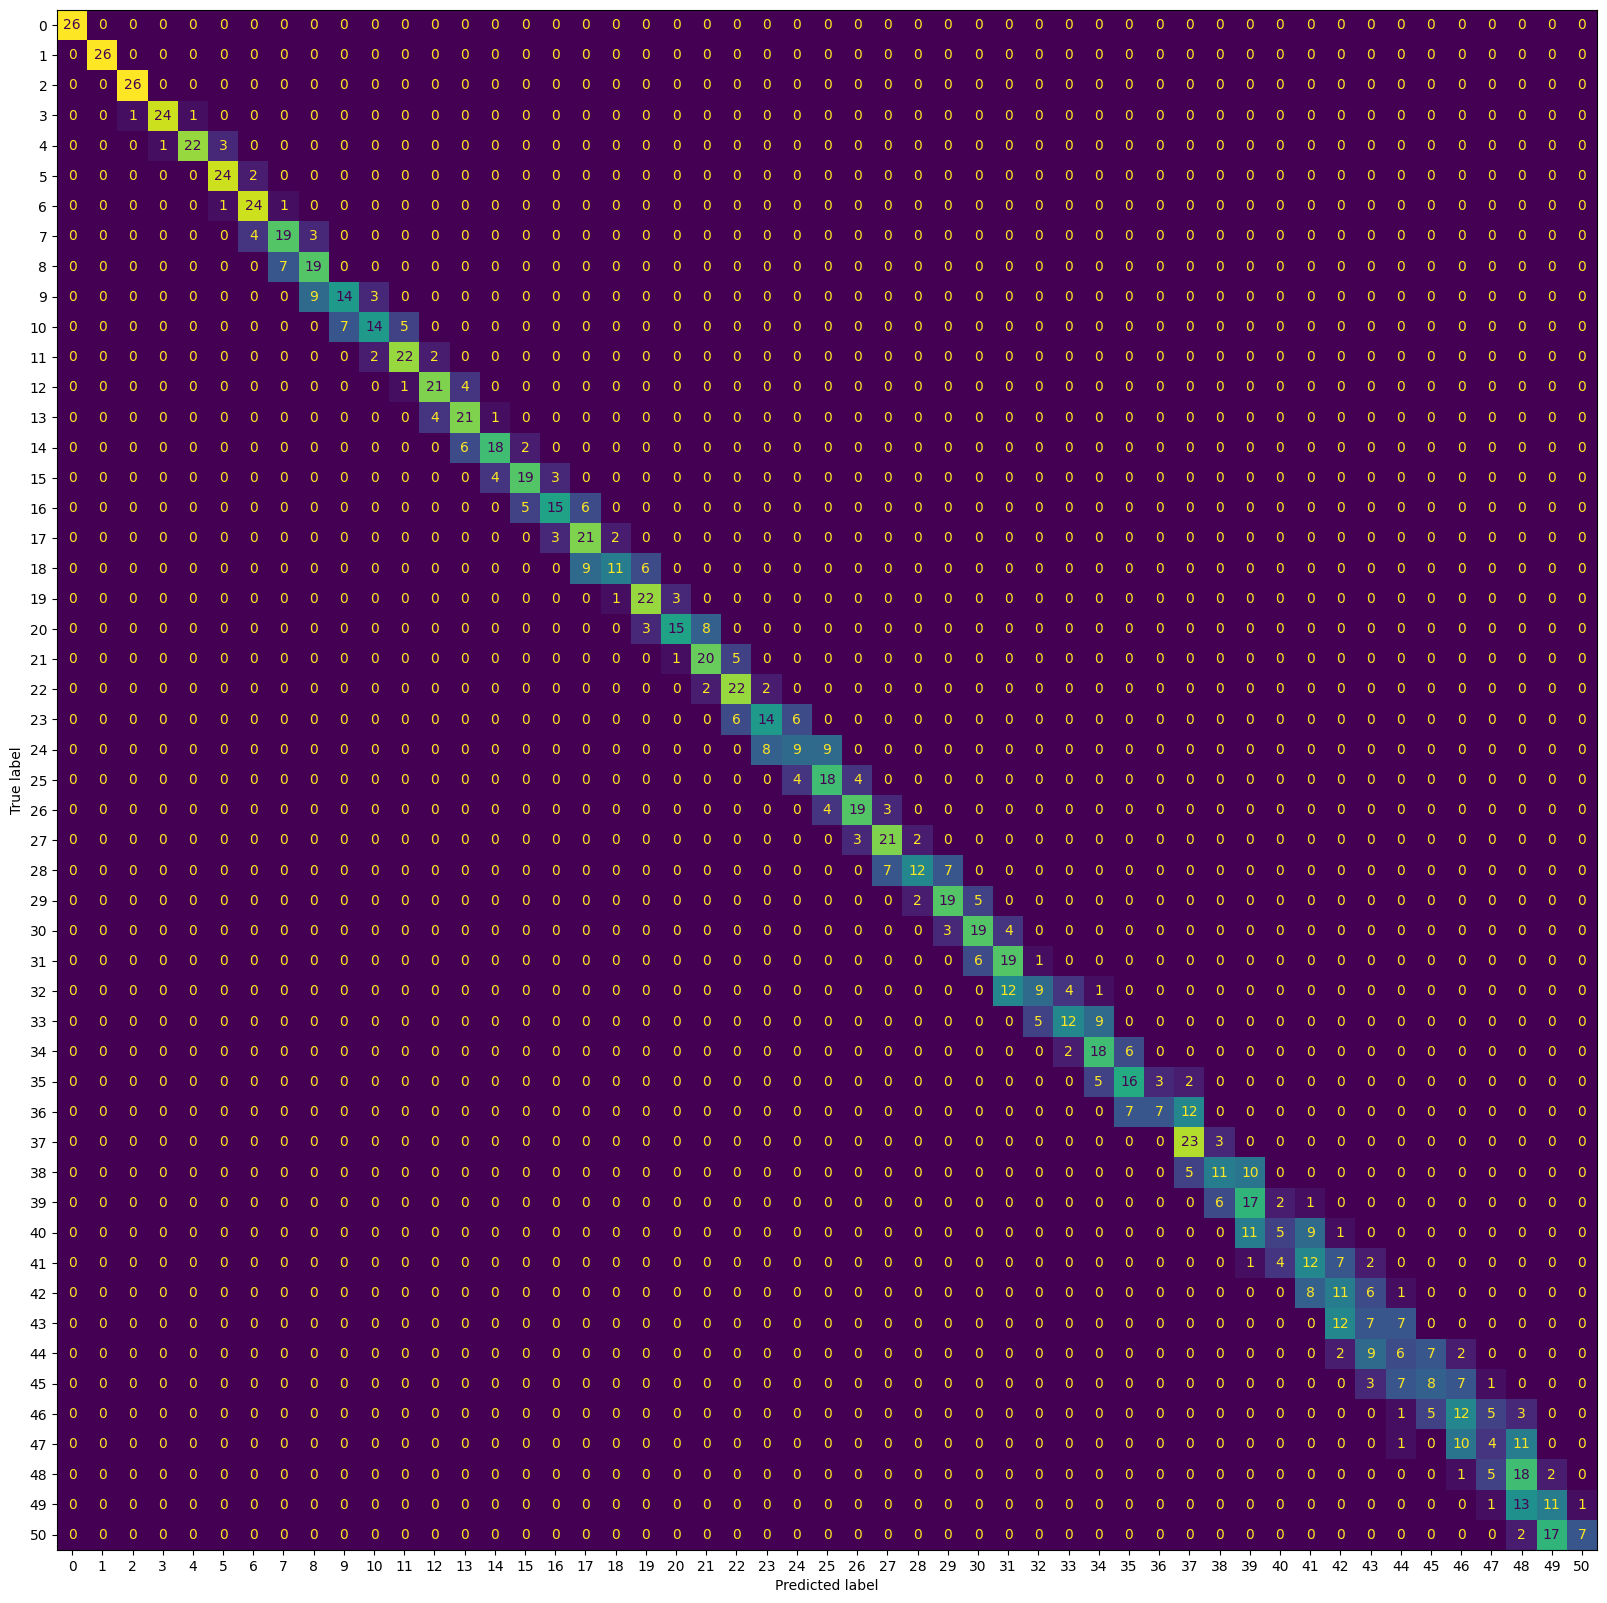

testing on half_circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.7073906485671192
Erro Percentual Médio Absoluto: 1.3%


<Figure size 2000x2000 with 0 Axes>

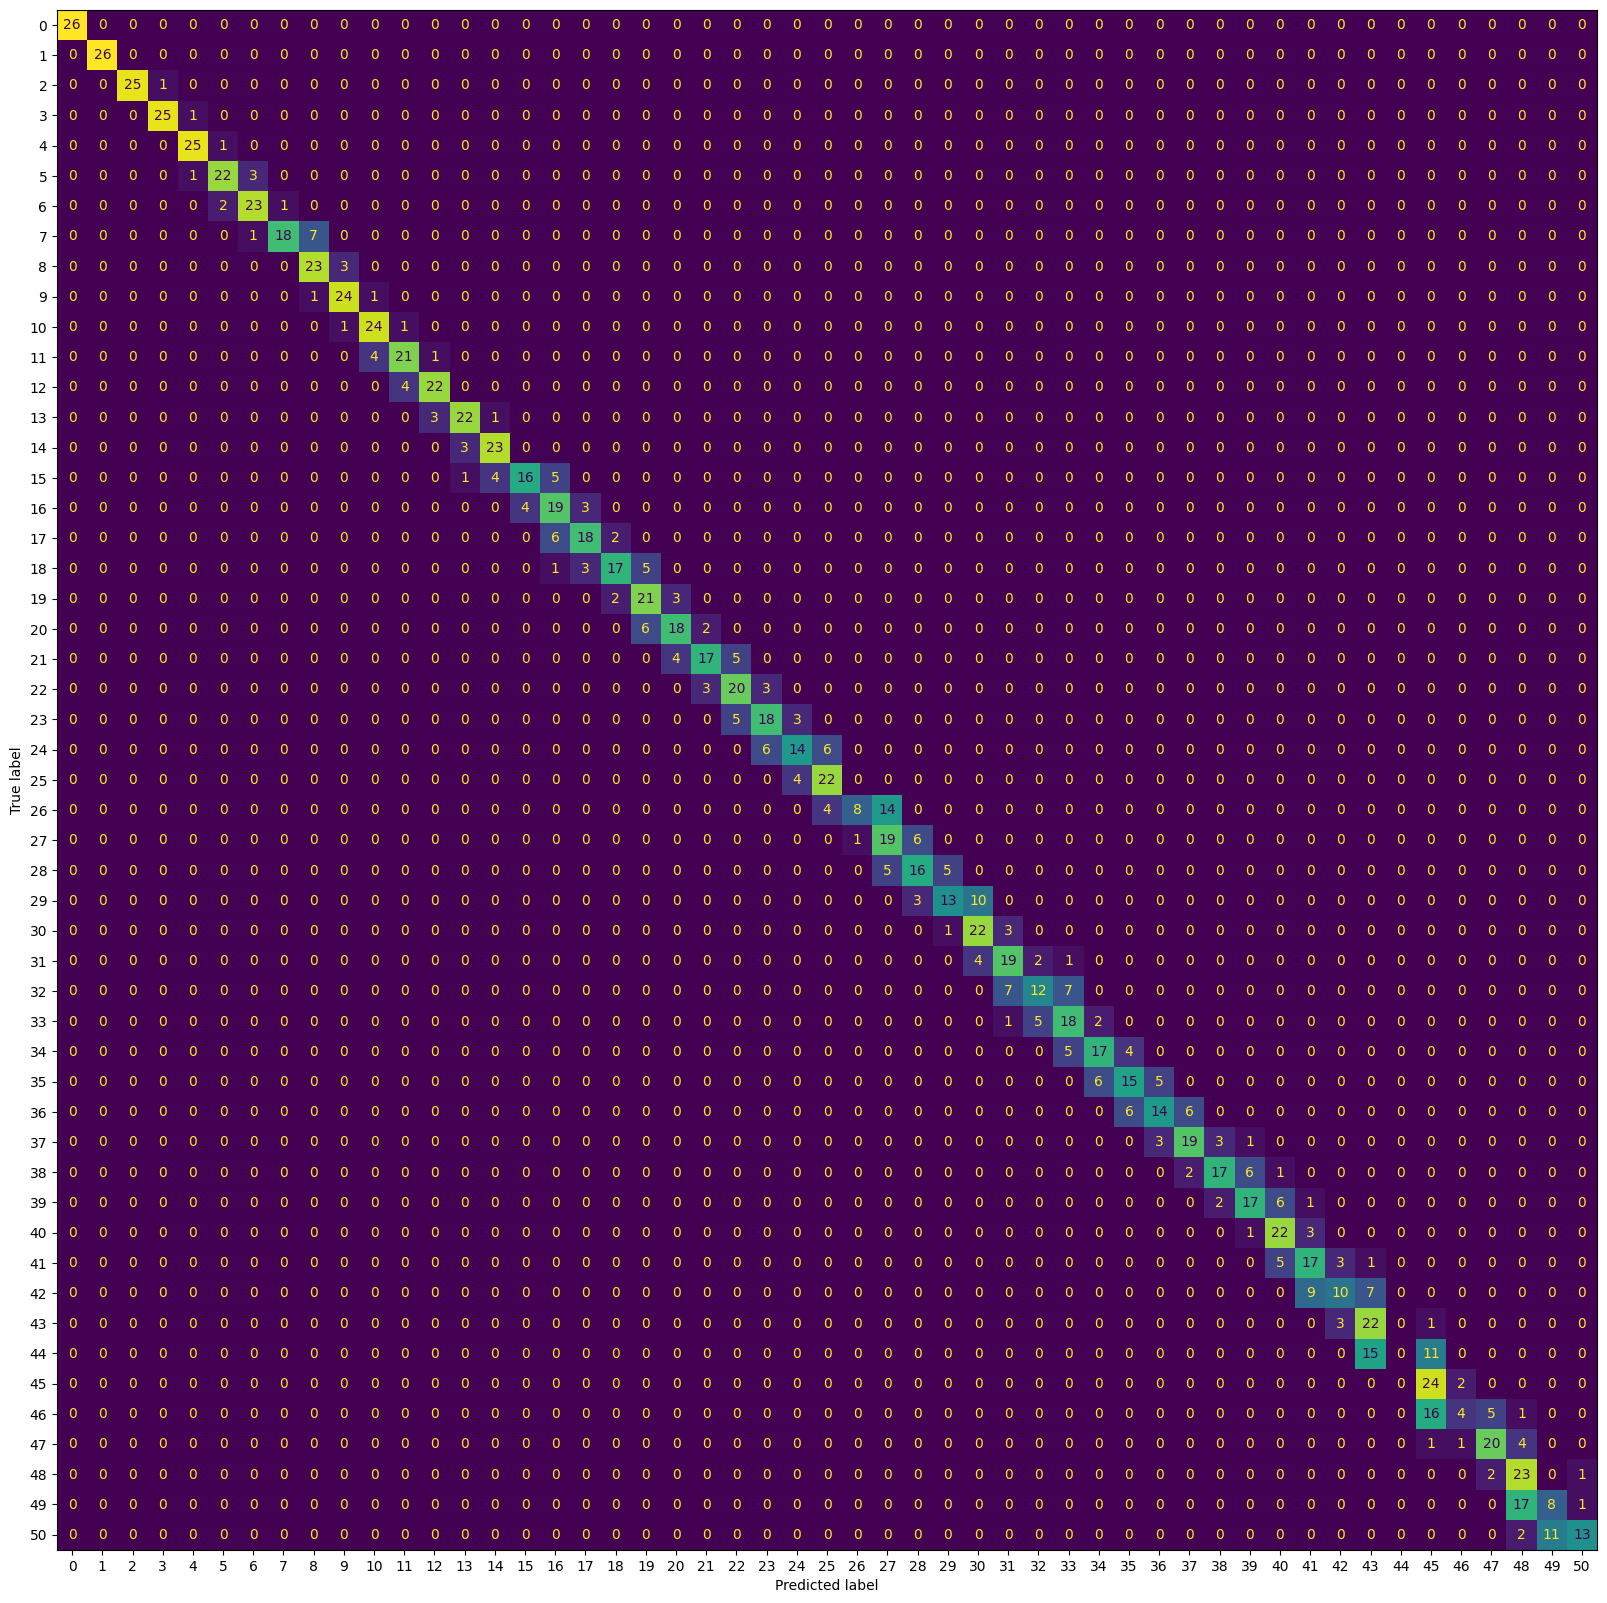

testing on c_sectorNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.6726998491704375
Erro Percentual Médio Absoluto: 1.4%


<Figure size 2000x2000 with 0 Axes>

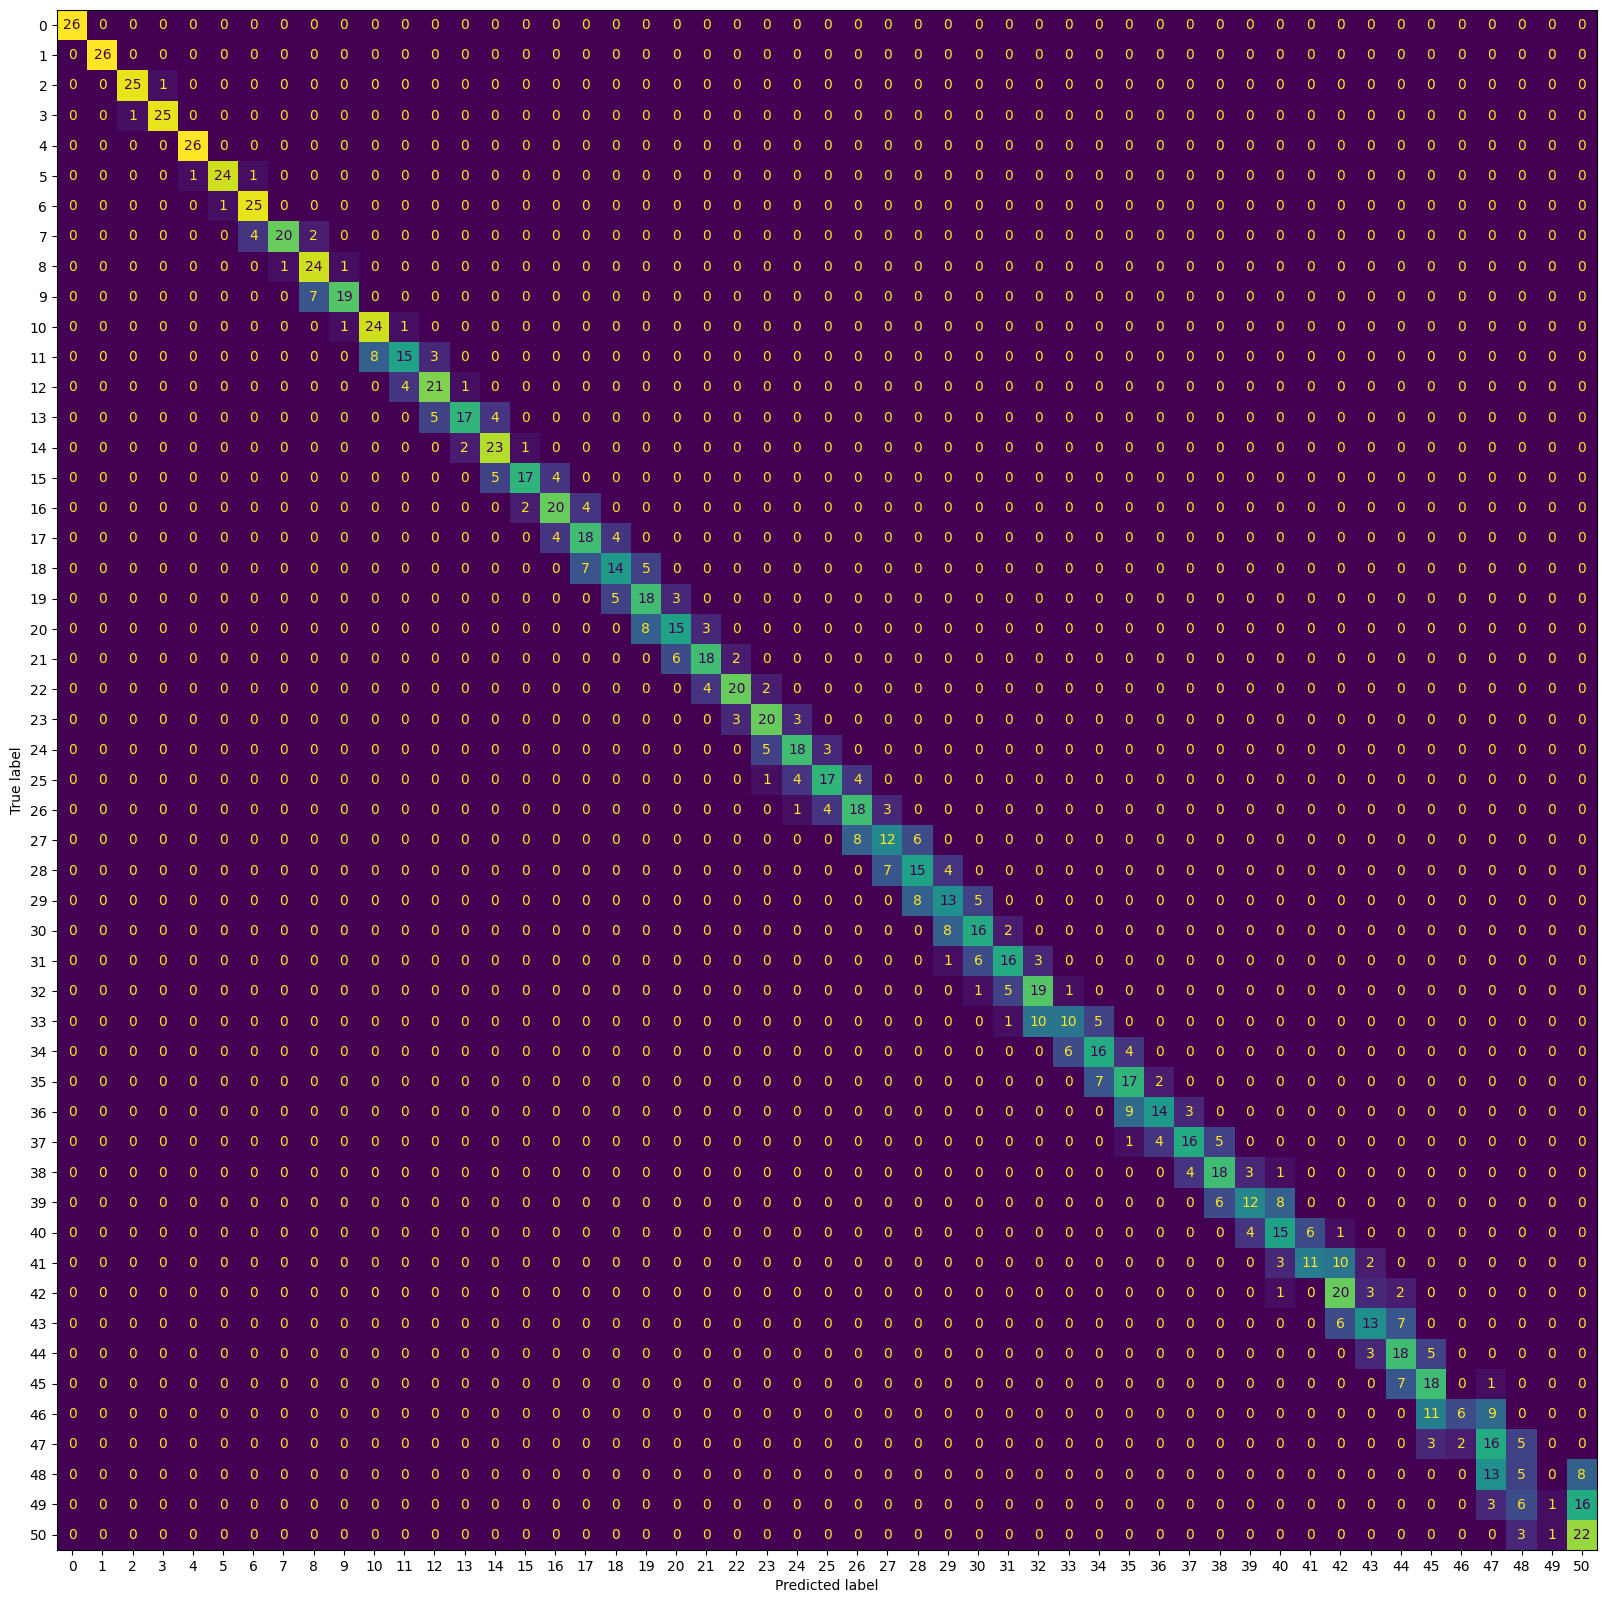

In [32]:
#aplicando essas redes no dataset de teste
for index, row in df_results.iterrows():
    xykeys=row['objecto']+'NN/test.json'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
    model=MiniLeNet().to(device)
    
    model.load_state_dict(torch.load(row['NetFile']))
    
    TestModel(model,xykeys,row['val_list'],row['key_list'],row['objecto'])
    
    del model, device
    torch.cuda.empty_cache()
    


## Segundo Experimento
Uma LeNet mais elaborada com bath normalization, que funcionou pior que a outra

In [12]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out



#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [13]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='LeNets0'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    if iteritem['objecto']=='circle':
        folders0=['circleNN/train','circleNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNN/train','trapezoidNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNN/train','half_circleNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNN/train','c_sectorNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo LeNet
    model=LeNet5(51).to(device)

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

Epoch 1/200
----------
train loss: 0.1088, accuracy: 0.0541
validation loss: 0.0919, accuracy: 0.0941
 
Epoch 2/200
----------
train loss: 0.0839, accuracy: 0.1208
validation loss: 0.0757, accuracy: 0.1725
 
Epoch 3/200
----------
train loss: 0.0767, accuracy: 0.1561
validation loss: 0.0709, accuracy: 0.2188
 
Epoch 4/200
----------
train loss: 0.0724, accuracy: 0.1784
validation loss: 0.0627, accuracy: 0.2918
 
Epoch 5/200
----------
train loss: 0.0687, accuracy: 0.2067
validation loss: 0.0613, accuracy: 0.2792
 
Epoch 6/200
----------
train loss: 0.0681, accuracy: 0.2059
validation loss: 0.0687, accuracy: 0.1514
 
Epoch 7/200
----------
train loss: 0.0680, accuracy: 0.2071
validation loss: 0.0590, accuracy: 0.2855
 
Epoch 8/200
----------
train loss: 0.0644, accuracy: 0.2435
validation loss: 0.0595, accuracy: 0.2431
 
Epoch 9/200
----------
train loss: 0.0650, accuracy: 0.2337
validation loss: 0.0562, accuracy: 0.3067
 
Epoch 10/200
----------
train loss: 0.0623, accuracy: 0.2478
val

{'best_train_net': 'LeNets0/51class_lr1e-03_c_sector.h5', 'best_train_net_epc': 196, 'best_val_net': 'LeNets0/51class_lr1e-03_circle.h5', 'best_val_net_epc': 28, 'best_train': 0.9858823418617249, 'best_val': 0.4062744975090027}


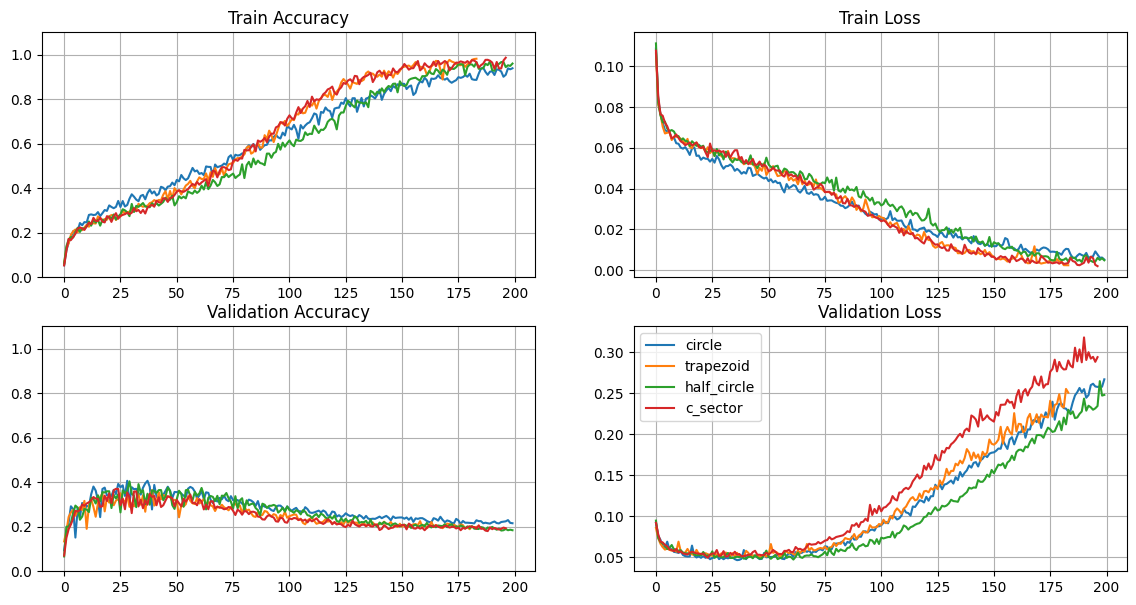

In [14]:
#Plotando os resultados importantes do treino dos modelos

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

## Terceiro Experimento
Vamos usar uma rede neural profunda mais moderna, a [EfficientNet](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0), aumentando nossas imagens para introduzi-las na rede

In [6]:
#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [7]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='Efnets0'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    if iteritem['objecto']=='circle':
        folders0=['circleNN/train','circleNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNN/train','trapezoidNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNN/train','half_circleNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNN/train','c_sectorNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
  
    model=models.efficientnet_b0().to(device)
    model.features[0][0]=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)
    model.classifier[1]=nn.Linear(1280, 51).to(device)
    

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

#salvamos esse dataframe
df_results.to_pickle('Efnets0/Efnets0.pkl')

Epoch 1/200
----------
train loss: 0.2033, accuracy: 0.0831
validation loss: 0.2894, accuracy: 0.0980
 
Epoch 2/200
----------
train loss: 0.1745, accuracy: 0.1314
validation loss: 0.1500, accuracy: 0.1992
 
Epoch 3/200
----------
train loss: 0.1638, accuracy: 0.1525
validation loss: 0.1377, accuracy: 0.2220
 
Epoch 4/200
----------
train loss: 0.1504, accuracy: 0.1831
validation loss: 0.1269, accuracy: 0.2855
 
Epoch 5/200
----------
train loss: 0.1377, accuracy: 0.2290
validation loss: 0.1246, accuracy: 0.2659
 
Epoch 6/200
----------
train loss: 0.1357, accuracy: 0.2420
validation loss: 0.1218, accuracy: 0.2878
 
Epoch 7/200
----------
train loss: 0.1246, accuracy: 0.2859
validation loss: 0.1131, accuracy: 0.3318
 
Epoch 8/200
----------
train loss: 0.1272, accuracy: 0.2690
validation loss: 0.1069, accuracy: 0.3420
 
Epoch 9/200
----------
train loss: 0.1174, accuracy: 0.3224
validation loss: 0.0973, accuracy: 0.4047
 
Epoch 10/200
----------
train loss: 0.1116, accuracy: 0.3376
val

{'best_train_net': 'Efnets0/51class_lr1e-03_circle.h5', 'best_train_net_epc': 181, 'best_val_net': 'Efnets0/51class_lr1e-03_circle.h5', 'best_val_net_epc': 170, 'best_train': 0.9835293889045715, 'best_val': 0.8815686106681824}


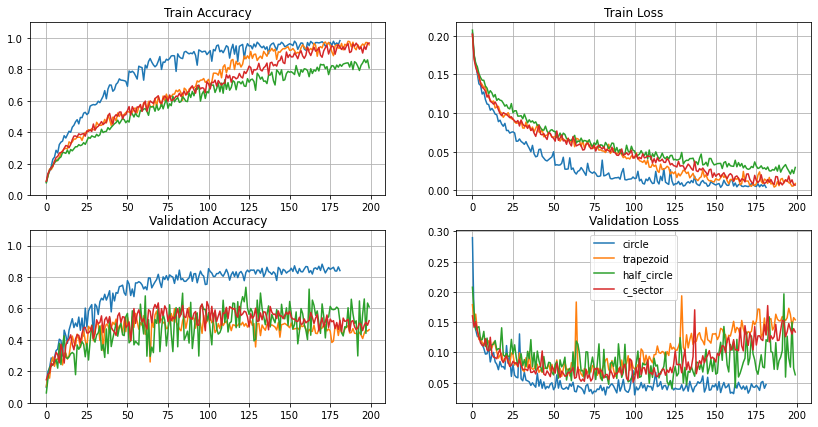

In [8]:
#Plotando os resultados importantes do treino dos modelos

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

testing on circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.8778280542986425
Erro Percentual Médio Absoluto: 0.5%


<Figure size 1440x1440 with 0 Axes>

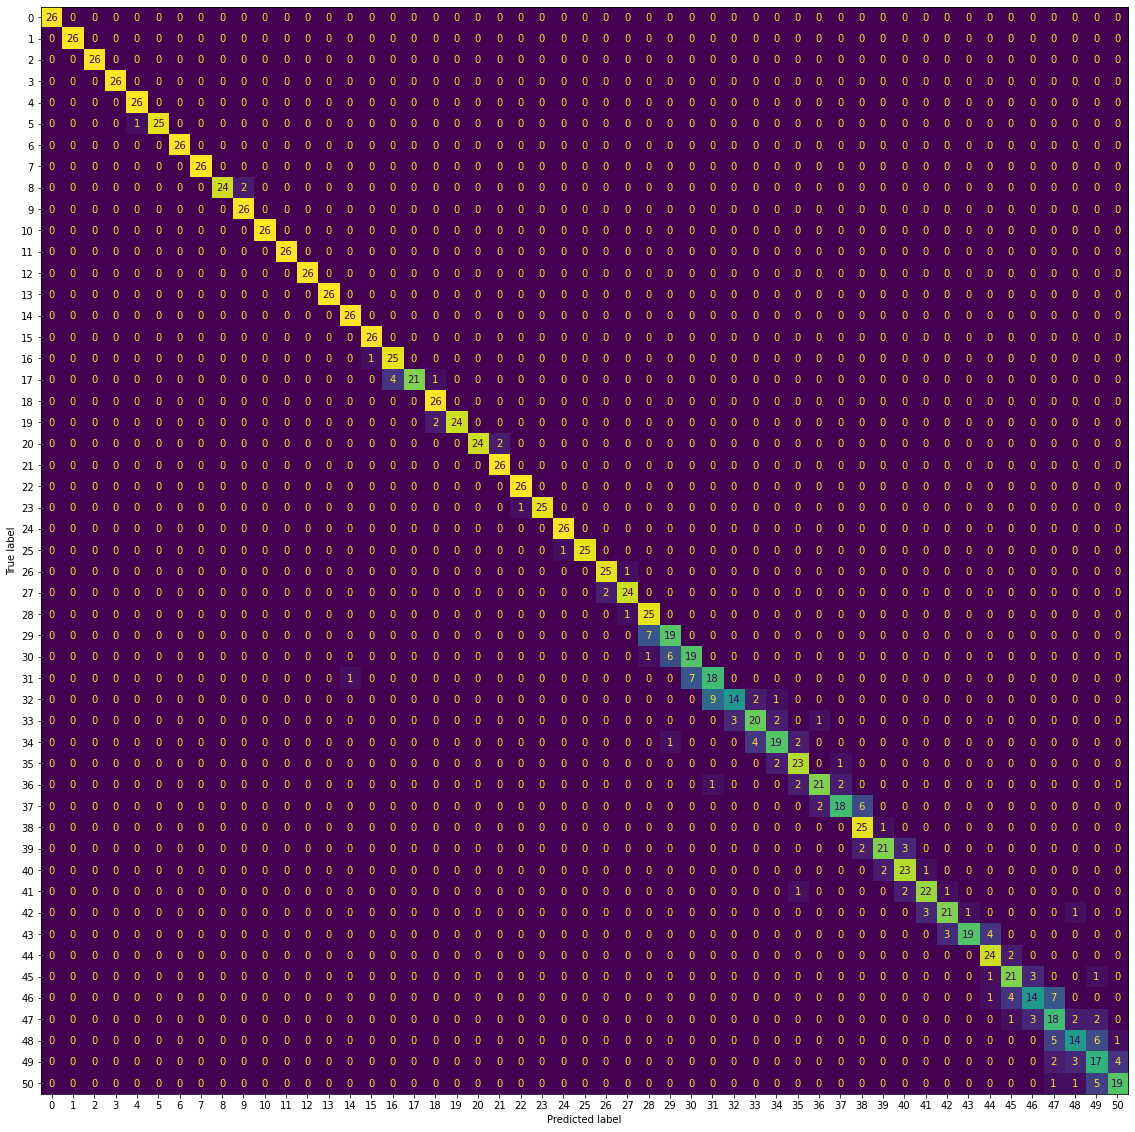

testing on trapezoidNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.5889894419306184
Erro Percentual Médio Absoluto: 1.8%


<Figure size 1440x1440 with 0 Axes>

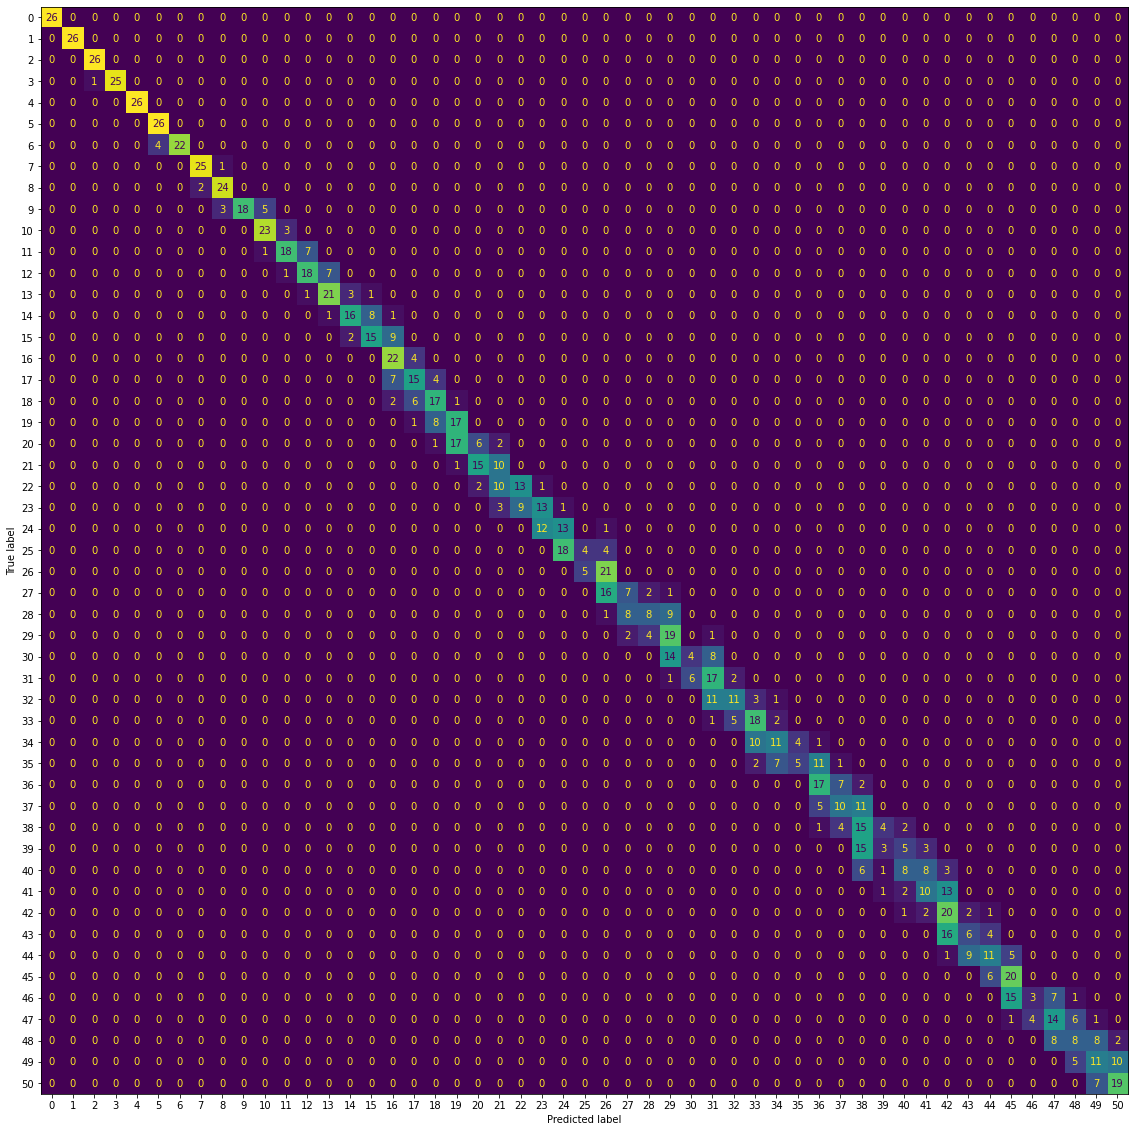

testing on half_circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.700603318250377
Erro Percentual Médio Absoluto: 1.3%


<Figure size 1440x1440 with 0 Axes>

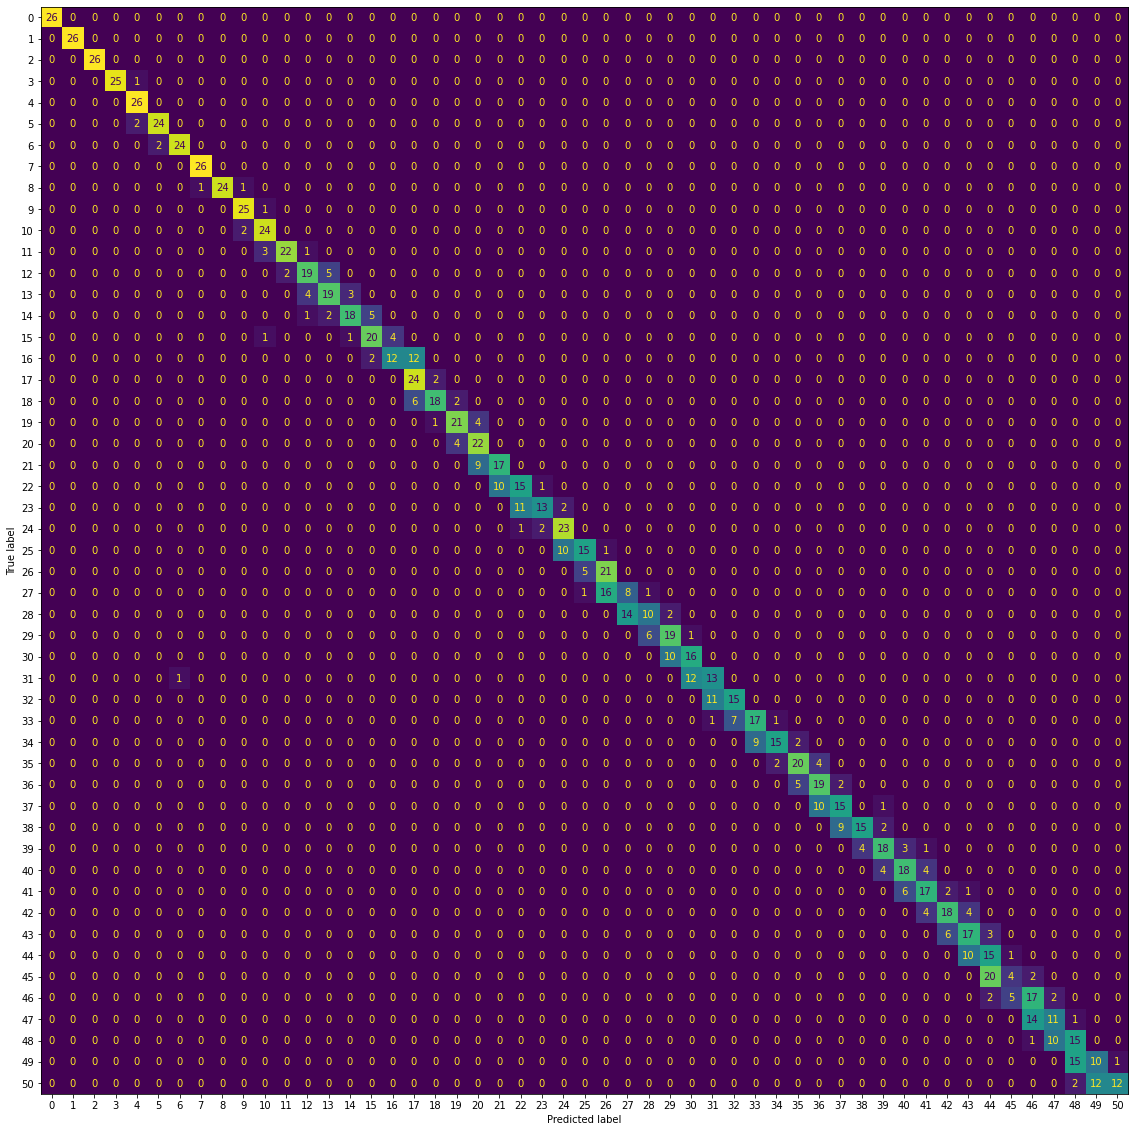

testing on c_sectorNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.6395173453996983
Erro Percentual Médio Absoluto: 1.6%


<Figure size 1440x1440 with 0 Axes>

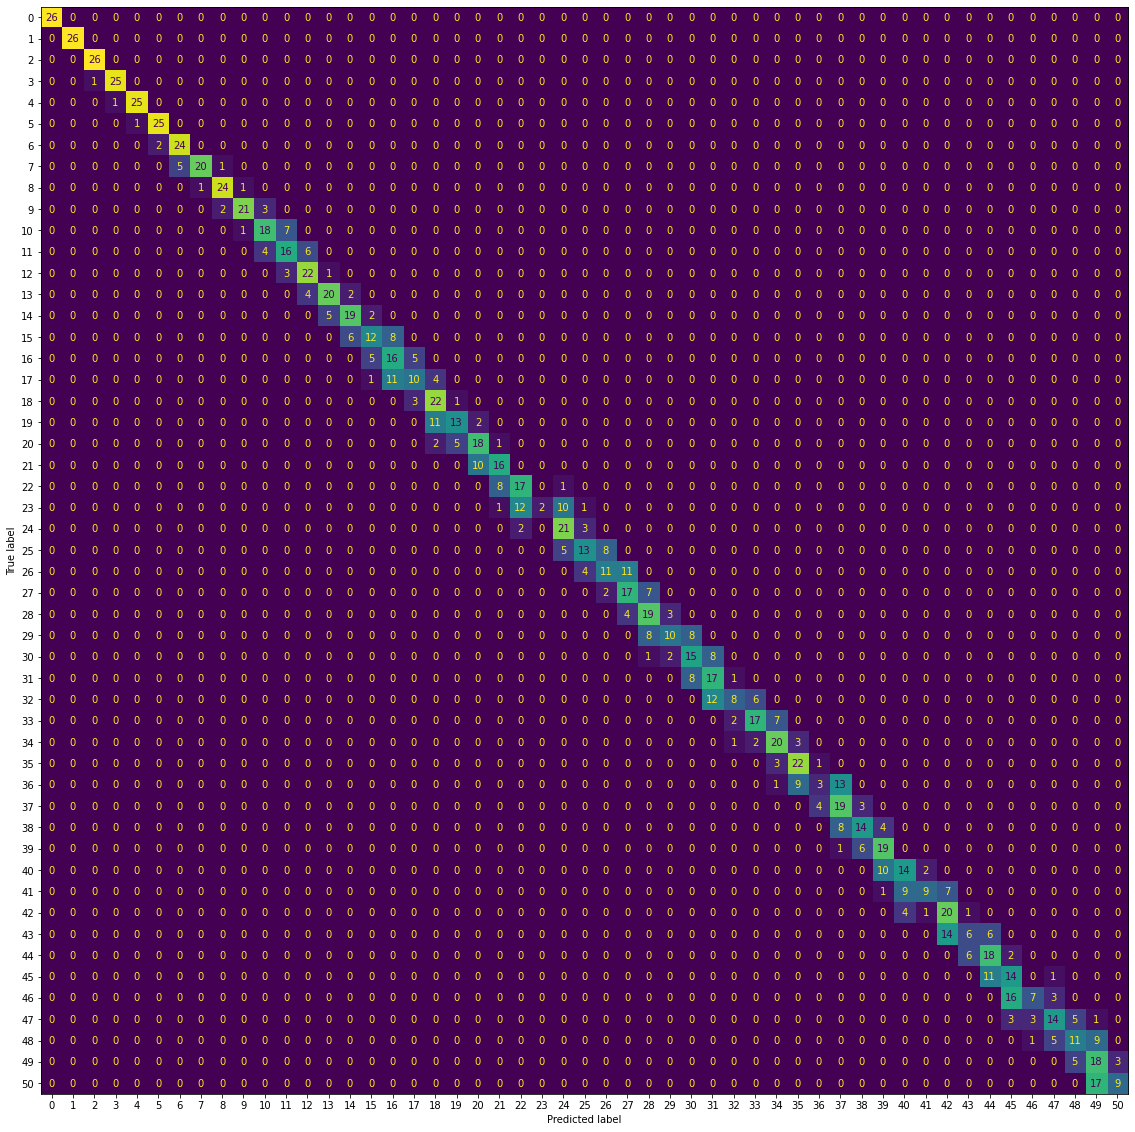

In [9]:
normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

#data transforms incluem as futuras 'data augumentations' que serão usadas
#são utilizados para compor o handler de datasets
model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])

#aplicando essas redes no dataset de teste
for index, row in df_results.iterrows():
    xykeys=row['objecto']+'NN/test.json'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo efnet pre treinado
    model=models.efficientnet_b0().to(device)
    model.features[0][0]=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)
    model.classifier[1]=nn.Linear(1280, 51).to(device)
    
    model.load_state_dict(torch.load(row['NetFile']))
    
    TestModel(model,xykeys,row['val_list'],row['key_list'],row['objecto'])
    
    del model, device
    torch.cuda.empty_cache()
    


## Primeiro Experimento com Scanlines, não hilbert
Usamos a rede disponivel em [um tutorial do pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) direcionado a treinar em cima do dataset CIFAR10, que tem a mesmo numero de pixels que nossas amostras, mas com apenas 3 camadas. Essa rede é uma LeNet5 simplificada

In [6]:
#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [7]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='MiniNets1'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    if iteritem['objecto']=='circle':
        folders0=['circleNNN/train','circleNNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNNN/train','trapezoidNNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNNN/train','half_circleNNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNNN/train','c_sectorNNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=64,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=64,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
    model=MiniLeNet().to(device)

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

#salvamos esse dataframe
df_results.to_pickle('MiniNets1/MiniNets1.pkl')

Epoch 1/200
----------
train loss: 0.0596, accuracy: 0.0255
validation loss: 0.0546, accuracy: 0.0345
 
Epoch 2/200
----------
train loss: 0.0499, accuracy: 0.0651
validation loss: 0.0439, accuracy: 0.1169
 
Epoch 3/200
----------
train loss: 0.0422, accuracy: 0.1114
validation loss: 0.0406, accuracy: 0.1678
 
Epoch 4/200
----------
train loss: 0.0386, accuracy: 0.1545
validation loss: 0.0369, accuracy: 0.1741
 
Epoch 5/200
----------
train loss: 0.0357, accuracy: 0.2012
validation loss: 0.0347, accuracy: 0.1890
 
Epoch 6/200
----------
train loss: 0.0339, accuracy: 0.2067
validation loss: 0.0324, accuracy: 0.2149
 
Epoch 7/200
----------
train loss: 0.0313, accuracy: 0.2580
validation loss: 0.0314, accuracy: 0.2416
 
Epoch 8/200
----------
train loss: 0.0295, accuracy: 0.2792
validation loss: 0.0290, accuracy: 0.2816
 
Epoch 9/200
----------
train loss: 0.0286, accuracy: 0.2788
validation loss: 0.0296, accuracy: 0.2957
 
Epoch 10/200
----------
train loss: 0.0277, accuracy: 0.3082
val

{'best_train_net': 'MiniNets1/51class_lr1e-03_circle.h5', 'best_train_net_epc': 189, 'best_val_net': 'MiniNets1/51class_lr1e-03_circle.h5', 'best_val_net_epc': 188, 'best_train': 0.9027450680732727, 'best_val': 0.7176470756530762}


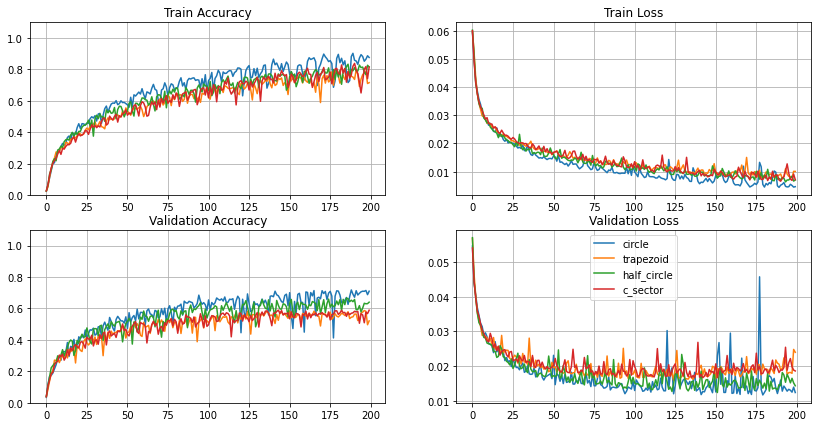

In [9]:
#Plotando os resultados importantes do treino dos modelos

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

testing on circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.45625942684766213
Erro Percentual Médio Absoluto: 5.3%


<Figure size 1440x1440 with 0 Axes>

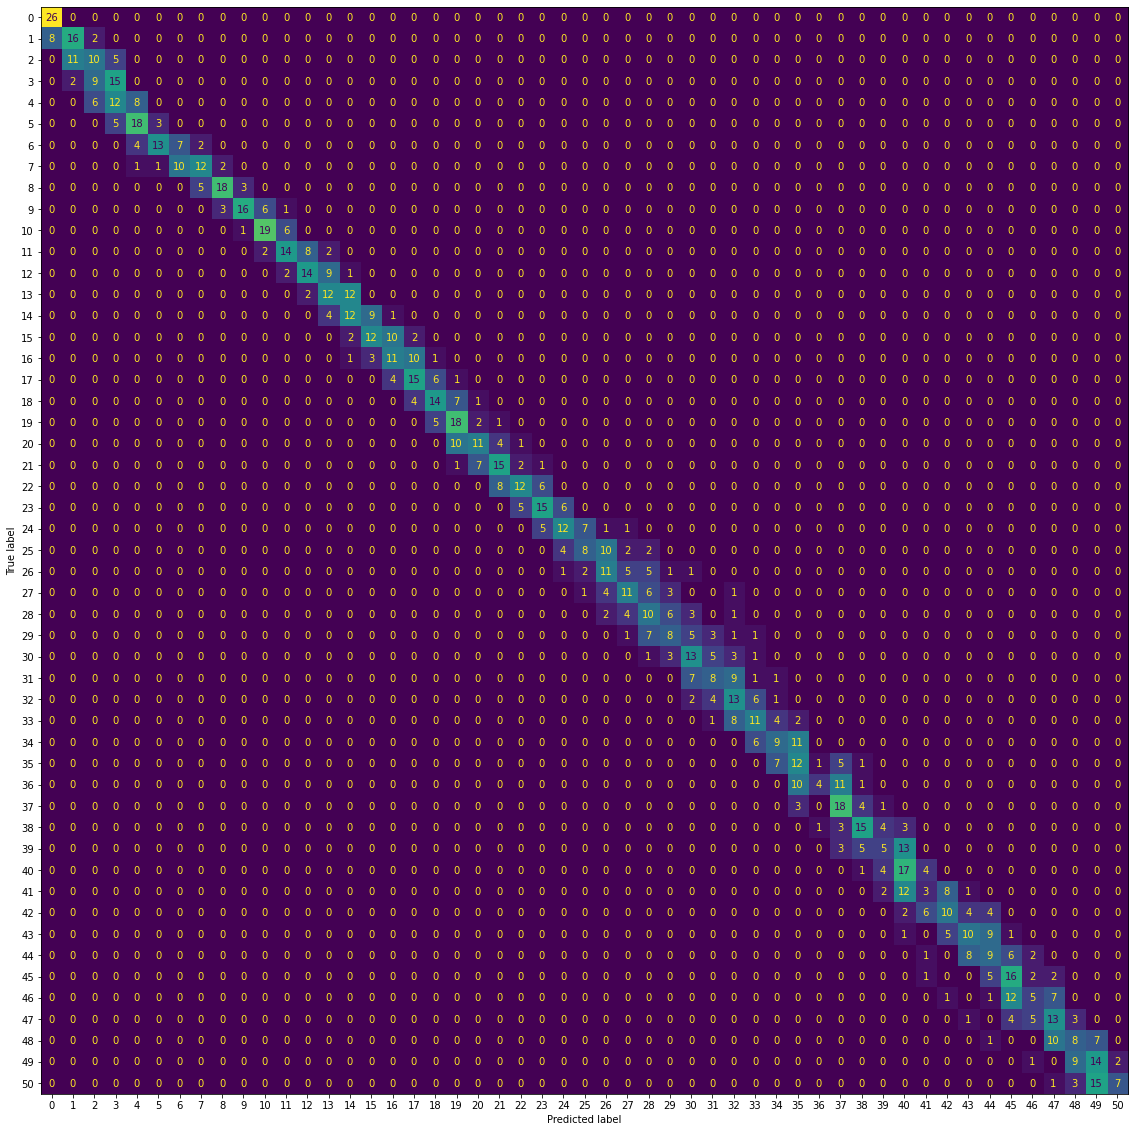

testing on trapezoidNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.42458521870286575
Erro Percentual Médio Absoluto: 4.3%


<Figure size 1440x1440 with 0 Axes>

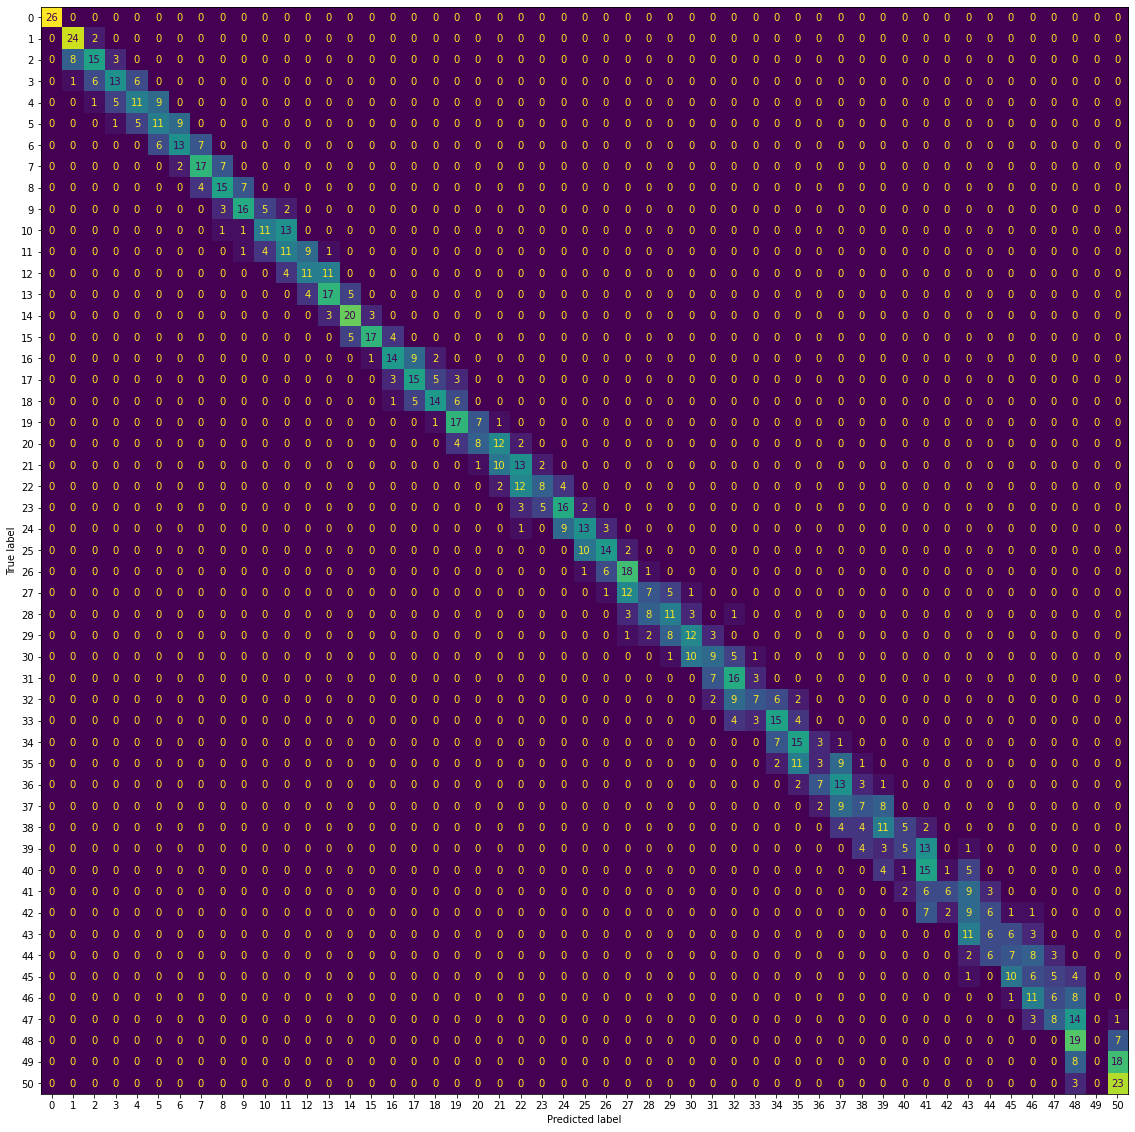

testing on half_circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.42684766214177977
Erro Percentual Médio Absoluto: 4.3%


<Figure size 1440x1440 with 0 Axes>

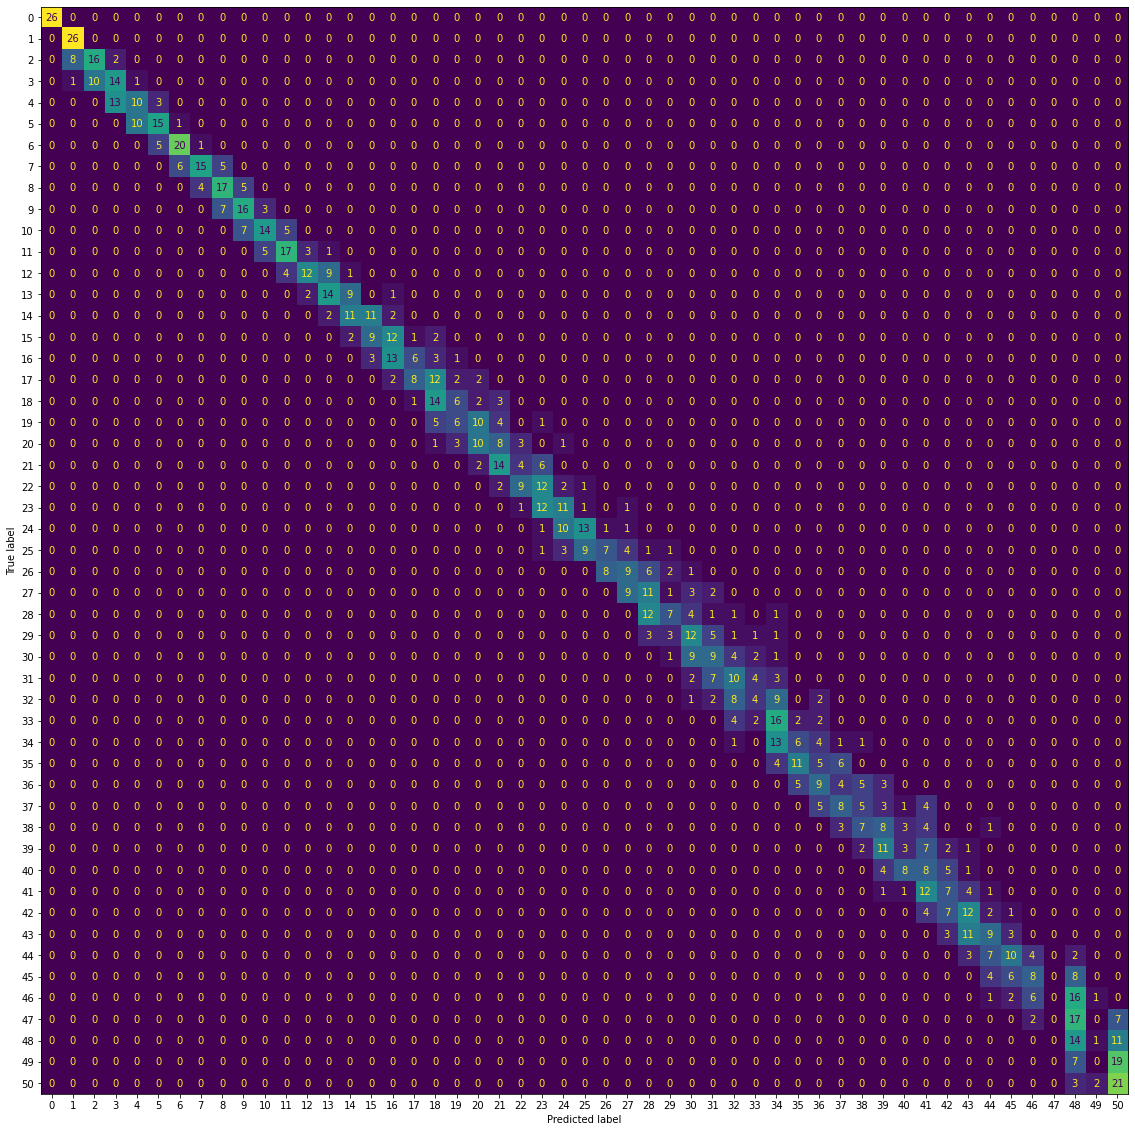

testing on c_sectorNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.4298642533936652
Erro Percentual Médio Absoluto: 4.8%


<Figure size 1440x1440 with 0 Axes>

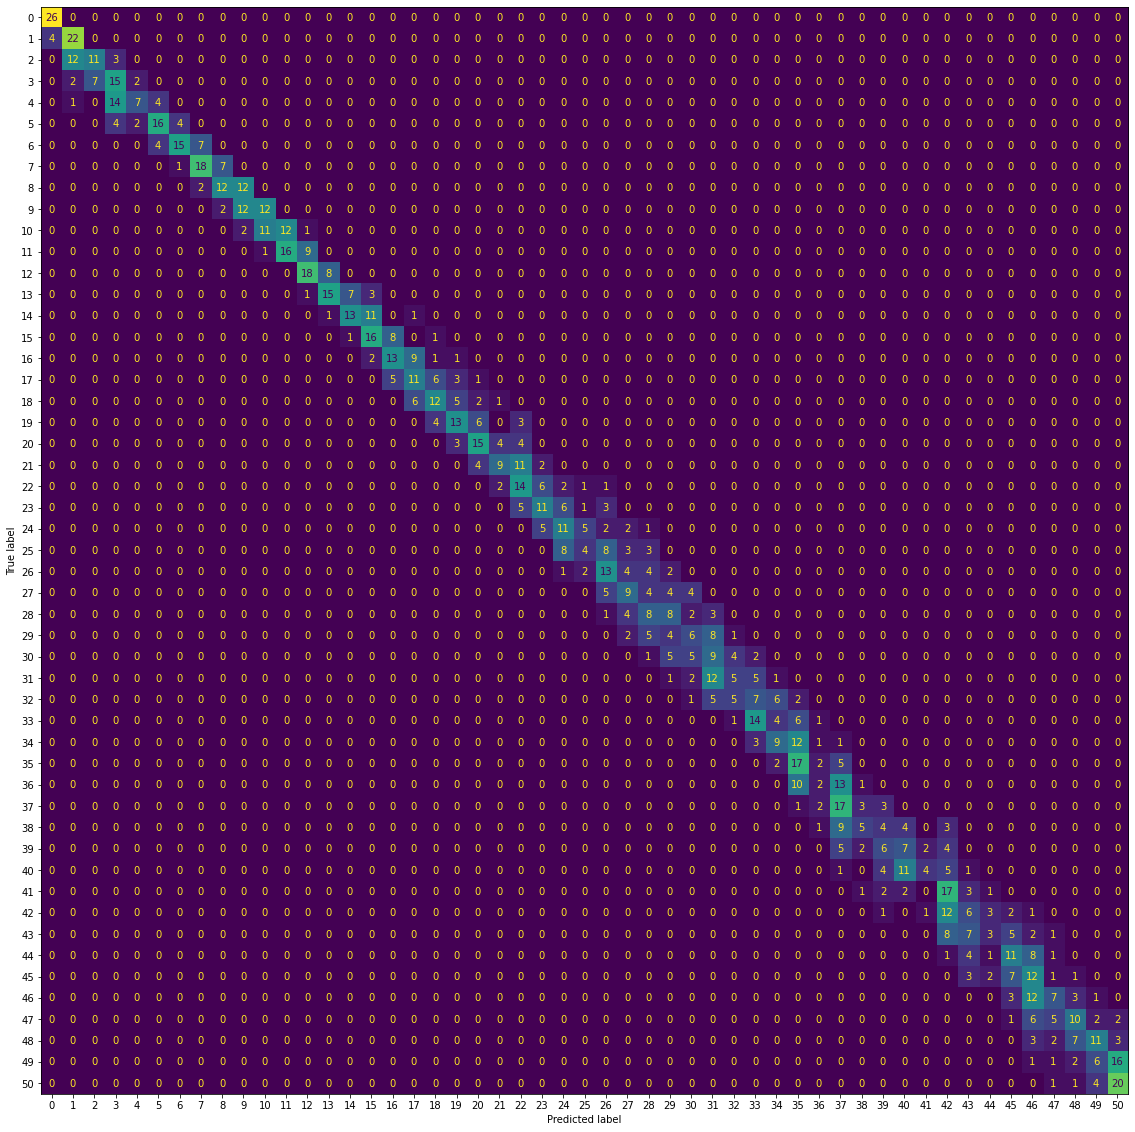

In [10]:
#aplicando essas redes no dataset de teste
for index, row in df_results.iterrows():
    xykeys=row['objecto']+'NN/test.json'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
    model=MiniLeNet().to(device)
    
    model.load_state_dict(torch.load(row['NetFile']))
    
    TestModel(model,xykeys,row['val_list'],row['key_list'],row['objecto'])
    
    del model, device
    torch.cuda.empty_cache()
    


## Segundo Experimento com Scanlines, não Hilbert
Vamos usar uma rede neural profunda mais moderna, a [EfficientNet](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0), aumentando nossas imagens para introduzi-las na rede

In [12]:
#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [13]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='Efnets1'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    
    if iteritem['objecto']=='circle':
        folders0=['circleNNN/train','circleNNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNNN/train','trapezoidNNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNNN/train','half_circleNNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNNN/train','c_sectorNNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=32,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=32,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo resnet50 pre treinado
  
    model=models.efficientnet_b0().to(device)
    model.features[0][0]=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)
    model.classifier[1]=nn.Linear(1280, 51).to(device)
    

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

#salvamos esse dataframe
df_results.to_pickle('Efnets1/Efnets1.pkl')

Epoch 1/200
----------
train loss: 0.0981, accuracy: 0.1051
validation loss: 0.0780, accuracy: 0.1286
 
Epoch 2/200
----------
train loss: 0.0799, accuracy: 0.1529
validation loss: 0.0721, accuracy: 0.2173
 
Epoch 3/200
----------
train loss: 0.0769, accuracy: 0.1710
validation loss: 0.0696, accuracy: 0.2196
 
Epoch 4/200
----------
train loss: 0.0739, accuracy: 0.1886
validation loss: 0.0772, accuracy: 0.1741
 
Epoch 5/200
----------
train loss: 0.0694, accuracy: 0.2106
validation loss: 0.0705, accuracy: 0.1953
 
Epoch 6/200
----------
train loss: 0.0672, accuracy: 0.2275
validation loss: 0.0769, accuracy: 0.2996
 
Epoch 7/200
----------
train loss: 0.0657, accuracy: 0.2325
validation loss: 0.0581, accuracy: 0.2455
 
Epoch 8/200
----------
train loss: 0.0622, accuracy: 0.2647
validation loss: 0.0561, accuracy: 0.3231
 
Epoch 9/200
----------
train loss: 0.0612, accuracy: 0.2753
validation loss: 0.0643, accuracy: 0.2620
 
Epoch 10/200
----------
train loss: 0.0572, accuracy: 0.3125
val

{'best_train_net': 'Efnets1/51class_lr1e-03_circle.h5', 'best_train_net_epc': 119, 'best_val_net': 'Efnets1/51class_lr1e-03_circle.h5', 'best_val_net_epc': 96, 'best_train': 0.9854902029037476, 'best_val': 0.8972548842430115}


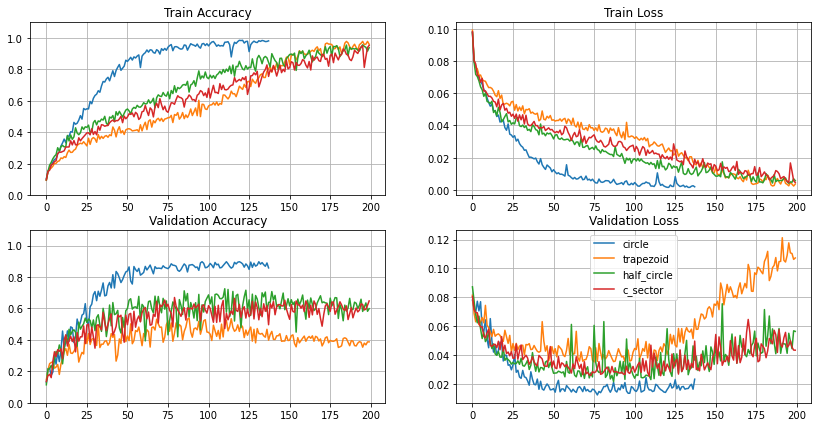

In [14]:
#Plotando os resultados importantes do treino dos modelos

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

testing on circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.25414781297134237
Erro Percentual Médio Absoluto: 19.4%


<Figure size 1440x1440 with 0 Axes>

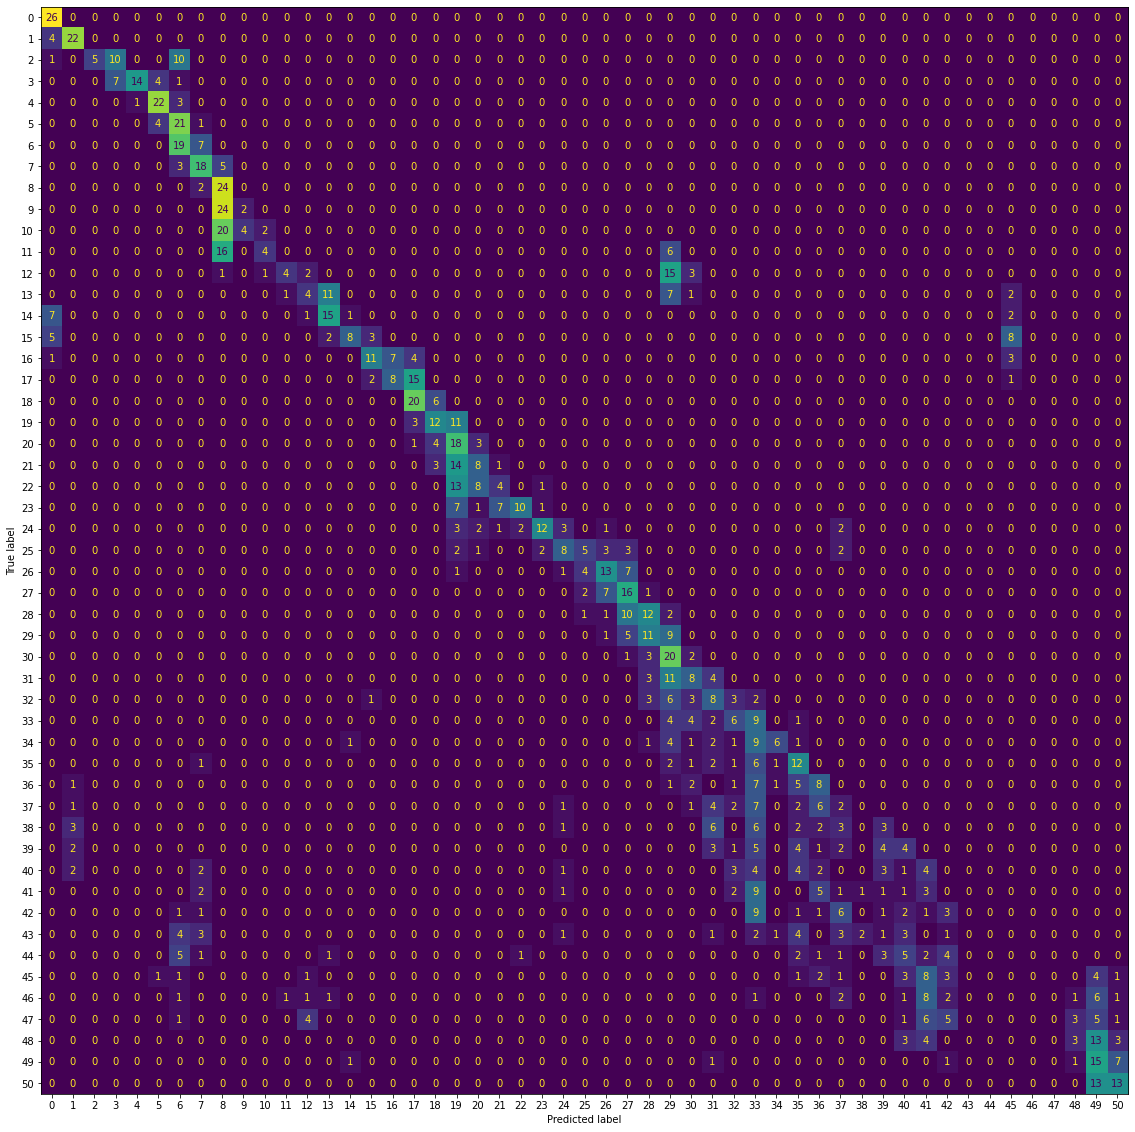

testing on trapezoidNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.46681749622926094
Erro Percentual Médio Absoluto: 7.4%


<Figure size 1440x1440 with 0 Axes>

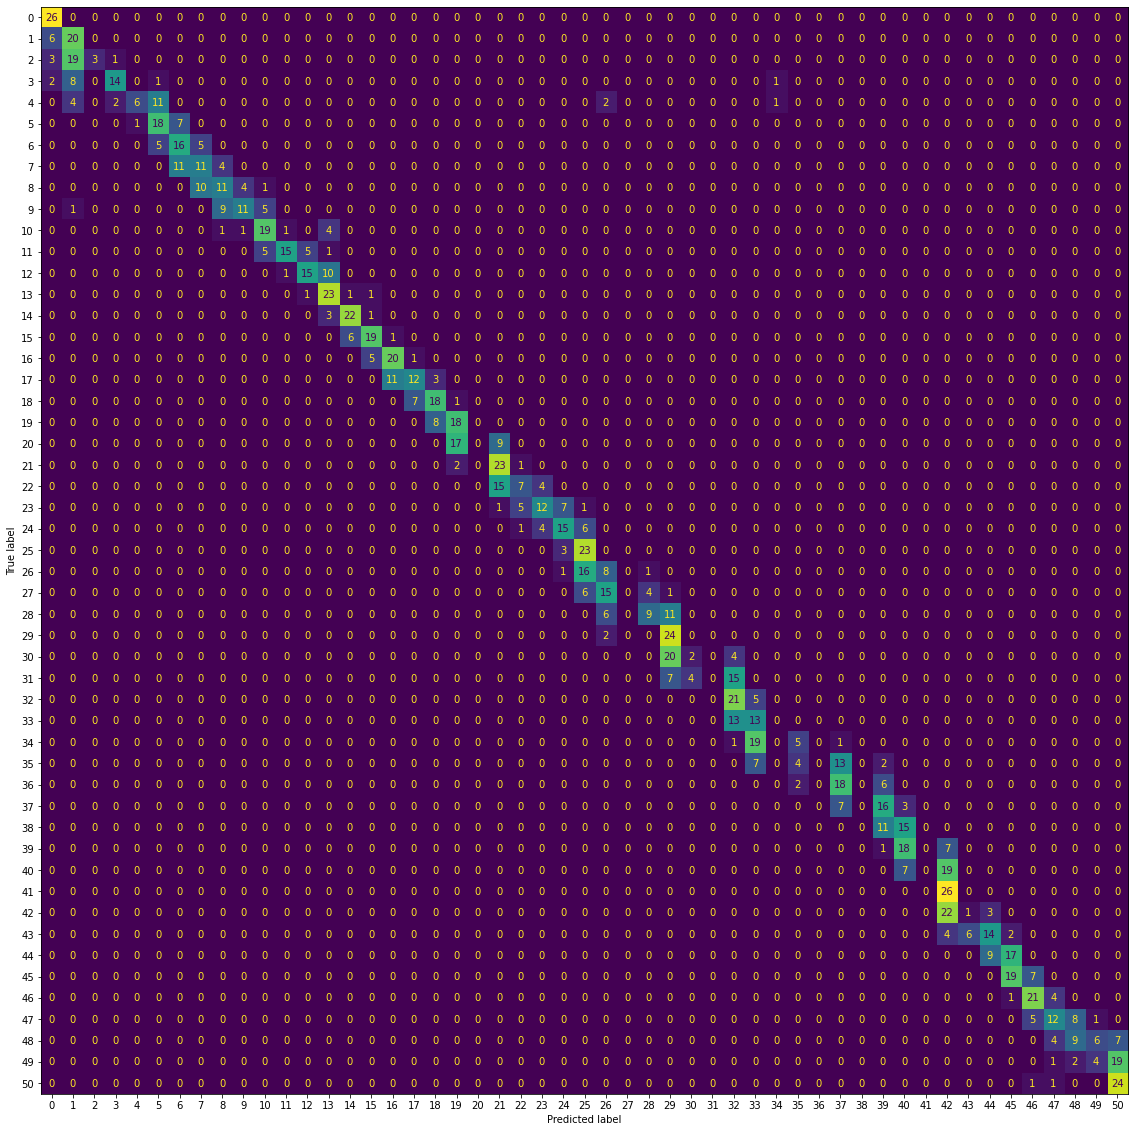

testing on half_circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.2888386123680241
Erro Percentual Médio Absoluto: 10.7%


<Figure size 1440x1440 with 0 Axes>

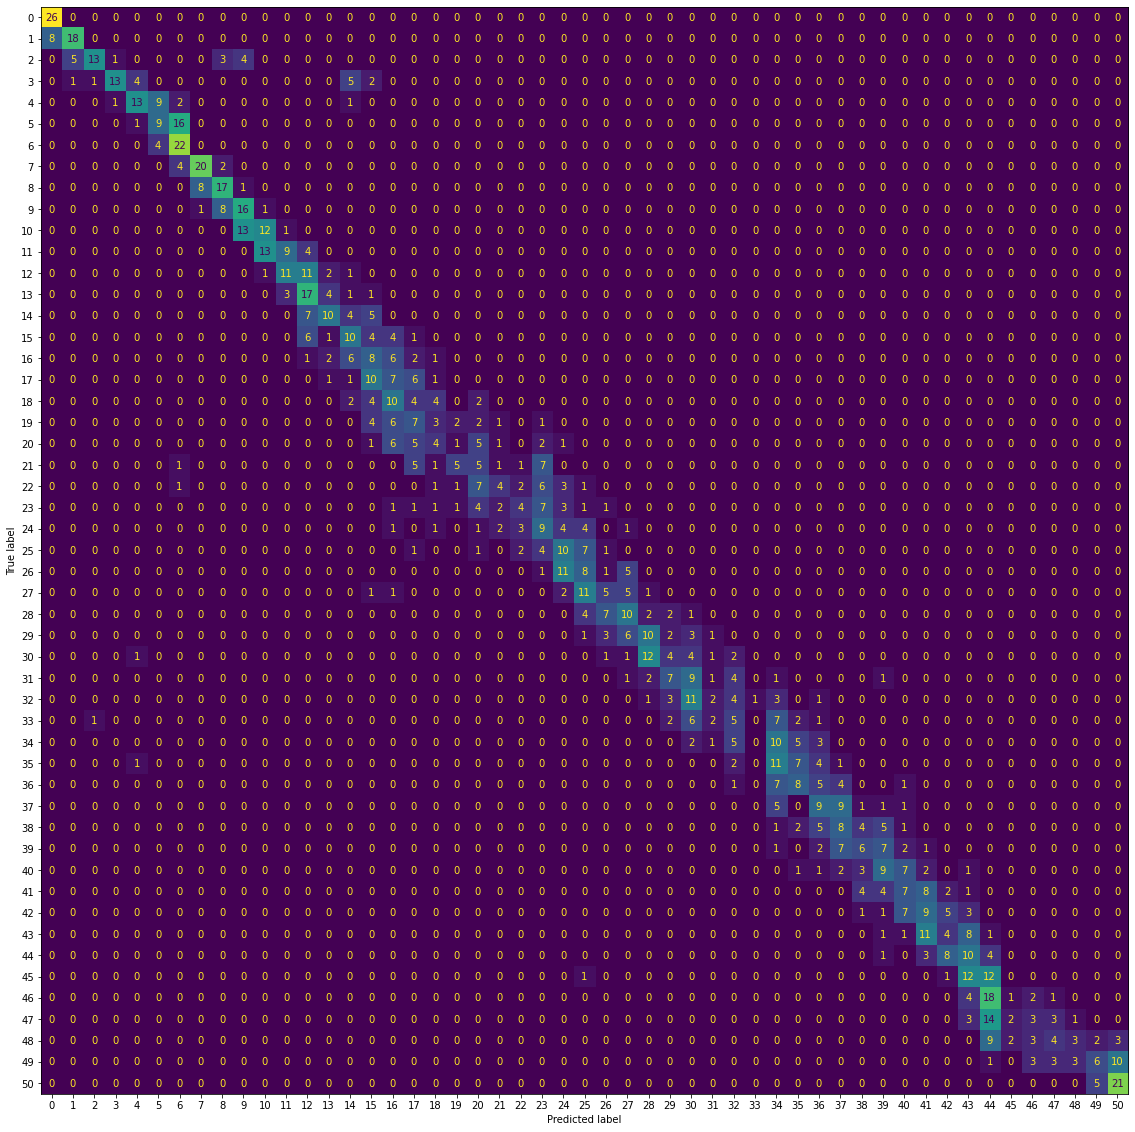

testing on c_sectorNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.2722473604826546
Erro Percentual Médio Absoluto: 8.0%


<Figure size 1440x1440 with 0 Axes>

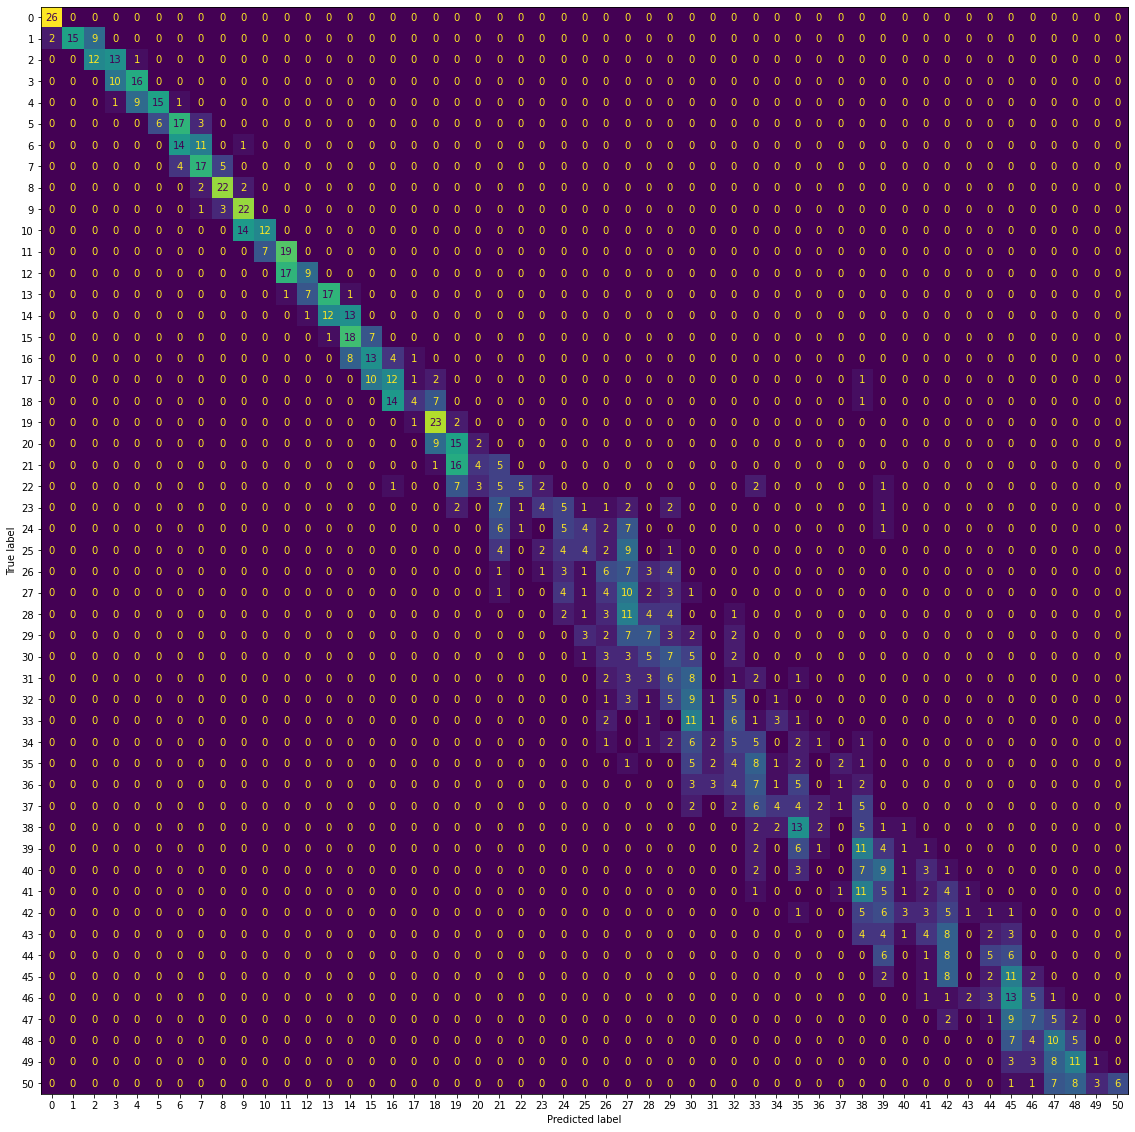

In [15]:
normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

#data transforms incluem as futuras 'data augumentations' que serão usadas
#são utilizados para compor o handler de datasets
model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])

#aplicando essas redes no dataset de teste
for index, row in df_results.iterrows():
    xykeys=row['objecto']+'NN/test.json'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo efnet pre treinado
    model=models.efficientnet_b0().to(device)
    model.features[0][0]=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)
    model.classifier[1]=nn.Linear(1280, 51).to(device)
    
    model.load_state_dict(torch.load(row['NetFile']))
    
    TestModel(model,xykeys,row['val_list'],row['key_list'],row['objecto'])
    
    del model, device
    torch.cuda.empty_cache()
    


## Quarto Experimento
Vamos usar outra rede neural profunda moderna, a [DenseNet](https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html#torchvision.models.densenet121), aumentando nossas imagens para introduzi-las na rede

In [6]:
#vamos iterar pelos seguintes learning rates para aprendizado do modelo
learningrates=[0.0010]
objects=['circle','trapezoid','half_circle','c_sector']


iterlist=[]


for lrate in learningrates:
    for objecto in objects:
        iteritem={}
        iteritem['lrate']=lrate
        iteritem['objecto']=objecto
        iterlist.append(iteritem)

a=0
for iteritem in iterlist[:]:
    print(a,iteritem)
    a=a+1
    print('')

0 {'lrate': 0.001, 'objecto': 'circle'}

1 {'lrate': 0.001, 'objecto': 'trapezoid'}

2 {'lrate': 0.001, 'objecto': 'half_circle'}

3 {'lrate': 0.001, 'objecto': 'c_sector'}



In [ ]:



#salvamos os modelos intermediarios e finais nesse diretório
savefolder='densenets0'
Path(savefolder).mkdir(parents=True, exist_ok=True)

#por este numero de épocas por modelo
epochs=200

#resultados importantes são guardados em dicionários nessa lista
testsoutputs=[]

for iteritem in iterlist[:]: 
    ###############################################################################
    ##########################Criação de Transforms e Classes######################
    
    if iteritem['objecto']=='circle':
        folders0=['circleNN/train','circleNN/val']
    if iteritem['objecto']=='trapezoid':
        folders0=['trapezoidNN/train','trapezoidNN/val']
    if iteritem['objecto']=='half_circle':
        folders0=['half_circleNN/train','half_circleNN/val']
    if iteritem['objecto']=='c_sector':
        folders0=['c_sectorNN/train','c_sectorNN/val']
        
    
    #normalize espalha os dados ao redor, mas aqui ele está desabilitado
    normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

    #data transforms incluem as futuras 'data augumentations' que serão usadas
    #são utilizados para compor o handler de datasets
    model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])
    
    image_datasets = {
        'train': 
        datasets.DatasetFolder(folders0[0], transform=model_transform,loader=npy_loader, extensions=['.npy']),
        'validation': 
        datasets.DatasetFolder(folders0[1], transform=model_transform,loader=npy_loader, extensions=['.npy'])
    }

    #os dataloaders separam os datasets dados pelo handler de datasets em batches e gerencia como estes são
    #encaminhados para a GPU
    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=8,
                                    shuffle=True, num_workers=4),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=8,
                                    shuffle=False, num_workers=4)
    }
    
    ###############################################################################
    ##########################Criação da Rede ###############################
    #testoutput é um dicionario onde guardamos as infos relevantes de cada modelo treinado dentro do for loop
    testoutput={}
    
    #guarda o learning rate
    testoutput['lrate']=iteritem['lrate']
    testoutput['objecto']=iteritem['objecto']
    
    #guarda o nome do modelo na pasta
    NetFile=os.path.join(savefolder,'51class'+'_lr'+"{:.0e}".format(iteritem['lrate'])+'_'+iteritem['objecto']+'.h5')
    testoutput['NetFile']=NetFile
    
    #abre um dispositivo na gpu, o objeto aonde carregamos os tensores dos modelos    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo densenet121
    model=models.densenet169().to(device)
    model.features.conv0=nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
    model.classifier=nn.Linear(in_features=1664, out_features=51, bias=True).to(device)
    

    #instanciamos que queremos tirar o gradiente de todos os parametros para treinar a rede
    for param in model.parameters():
        param.requires_grad = True   
        
    #definimos o critério de perda
    criterion = nn.CrossEntropyLoss()
    
    #definimos o otimizador, especificando o learning rate (podemos colocar outras coisas, como
    #weight decay e learning rate decay, se for desejado)
    optimizer = optim.Adam(model.parameters(),lr=iteritem['lrate'])
    
    ###############################################################################
    ############################Treinando o Modelo#################################
    #treinamos o modelo de acordo com o algoritmo instanciado acima     
    model_trained, loss_curve, acc_curve = train_model(model, criterion, optimizer, NetFile, num_epochs=epochs)

    #logamos os resultados
    testoutput['loss_curve']=loss_curve
    testoutput['acc_curve']=acc_curve
                          
    #logamos as relações entre a saida numérica do modelo e as classses semanticas que registramos
    #ex (lixo:1,papelão:0,etc)
    relations = dataloaders['train'].dataset.class_to_idx
    key_list = list(relations.keys())
    val_list = list(relations.values())
                          
    testoutput['key_list']=key_list
    testoutput['val_list']=val_list
                                  
    testsoutputs.append(testoutput)
    
    #deletamos todas as variaveis e limpamos a GPU para a proxima iteração
    del image_datasets, dataloaders, relations, key_list, val_list, device, model, criterion, optimizer
    del model_trained
    torch.cuda.empty_cache()

#compilamos um dataframe da lista de dicionários criada
df_results = pd.DataFrame.from_dict(testsoutputs)

#salvamos esse dataframe
df_results.to_pickle('densenets0/densenets0.pkl')

Epoch 1/200
----------
train loss: 0.4183, accuracy: 0.0890
validation loss: 0.3547, accuracy: 0.1592
 
Epoch 2/200
----------
train loss: 0.3609, accuracy: 0.1251
validation loss: 0.3282, accuracy: 0.1443
 
Epoch 3/200
----------
train loss: 0.3413, accuracy: 0.1424
validation loss: 0.2923, accuracy: 0.1820
 
Epoch 4/200
----------
train loss: 0.3278, accuracy: 0.1553
validation loss: 0.3101, accuracy: 0.2243
 
Epoch 5/200
----------
train loss: 0.3025, accuracy: 0.1890
validation loss: 0.3123, accuracy: 0.2353
 
Epoch 6/200
----------
train loss: 0.2991, accuracy: 0.2055
validation loss: 0.2890, accuracy: 0.2243
 
Epoch 7/200
----------
train loss: 0.2840, accuracy: 0.2294
validation loss: 0.2632, accuracy: 0.2675
 
Epoch 8/200
----------
train loss: 0.2748, accuracy: 0.2278
validation loss: 0.2499, accuracy: 0.3176
 
Epoch 9/200
----------
train loss: 0.2677, accuracy: 0.2463
validation loss: 0.2420, accuracy: 0.3043
 
Epoch 10/200
----------
train loss: 0.2665, accuracy: 0.2537
val

{'best_train_net': 'densenets0/51class_lr1e-03_half_circle.h5', 'best_train_net_epc': 175, 'best_val_net': 'densenets0/51class_lr1e-03_circle.h5', 'best_val_net_epc': 132, 'best_train': 0.9831372499465942, 'best_val': 0.7780392169952393}


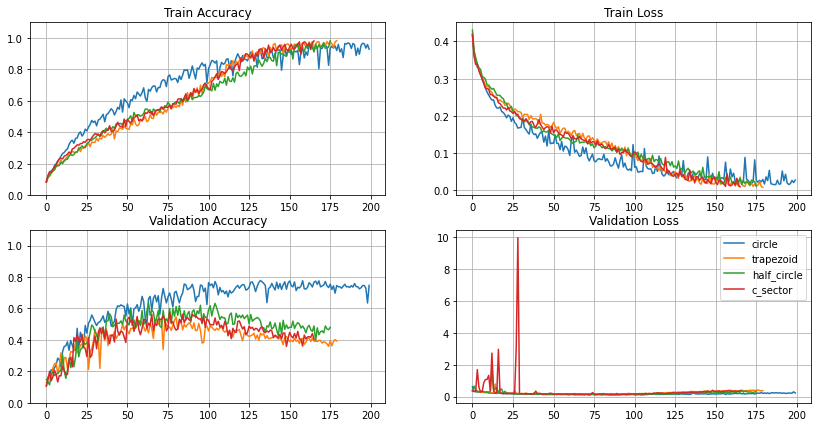

In [7]:
#Plotando os resultados importantes do treino dos modelos
df_results=pd.read_pickle('densenets0/densenets0.pkl')

f,d=ExperimentRun(df_results)

print(d)

plt.legend()
plt.show()  

testing on circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.7586726998491704
Erro Percentual Médio Absoluto: 1.5%


<Figure size 1440x1440 with 0 Axes>

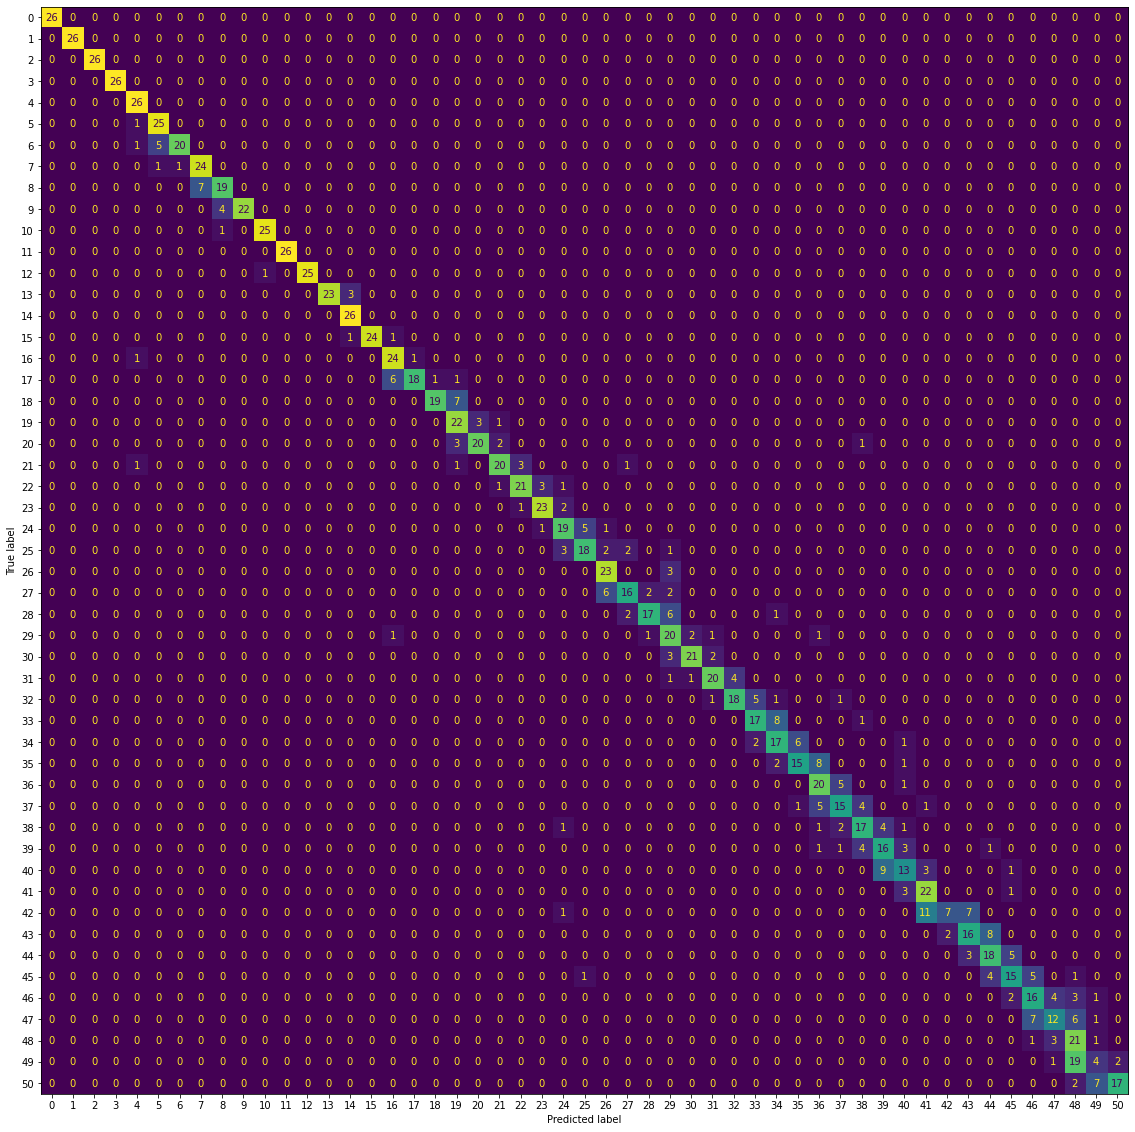

testing on trapezoidNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.5256410256410257
Erro Percentual Médio Absoluto: 2.5%


<Figure size 1440x1440 with 0 Axes>

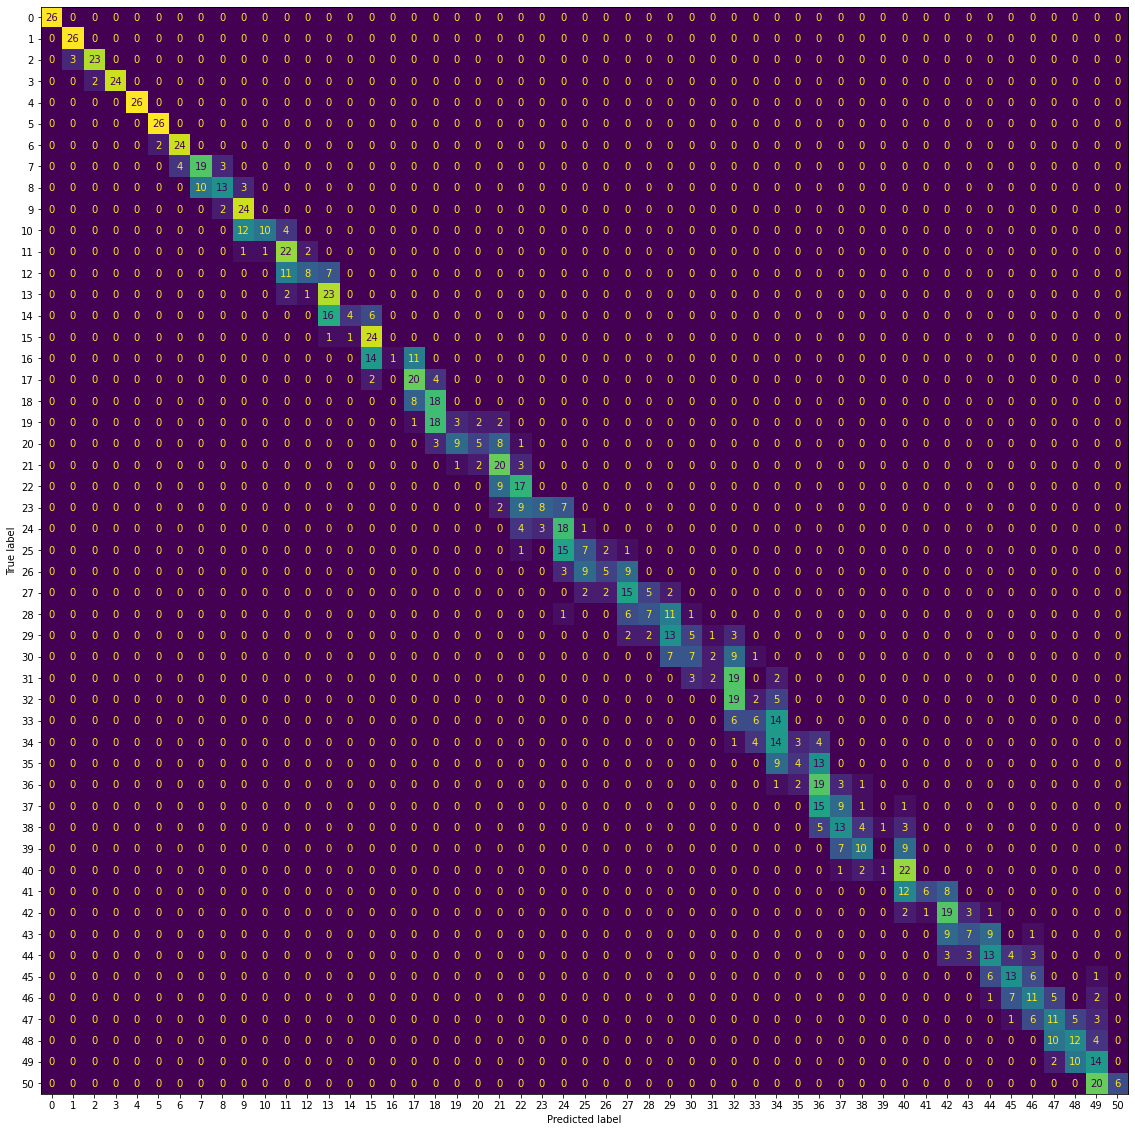

testing on half_circleNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.6025641025641025
Erro Percentual Médio Absoluto: 1.9%


<Figure size 1440x1440 with 0 Axes>

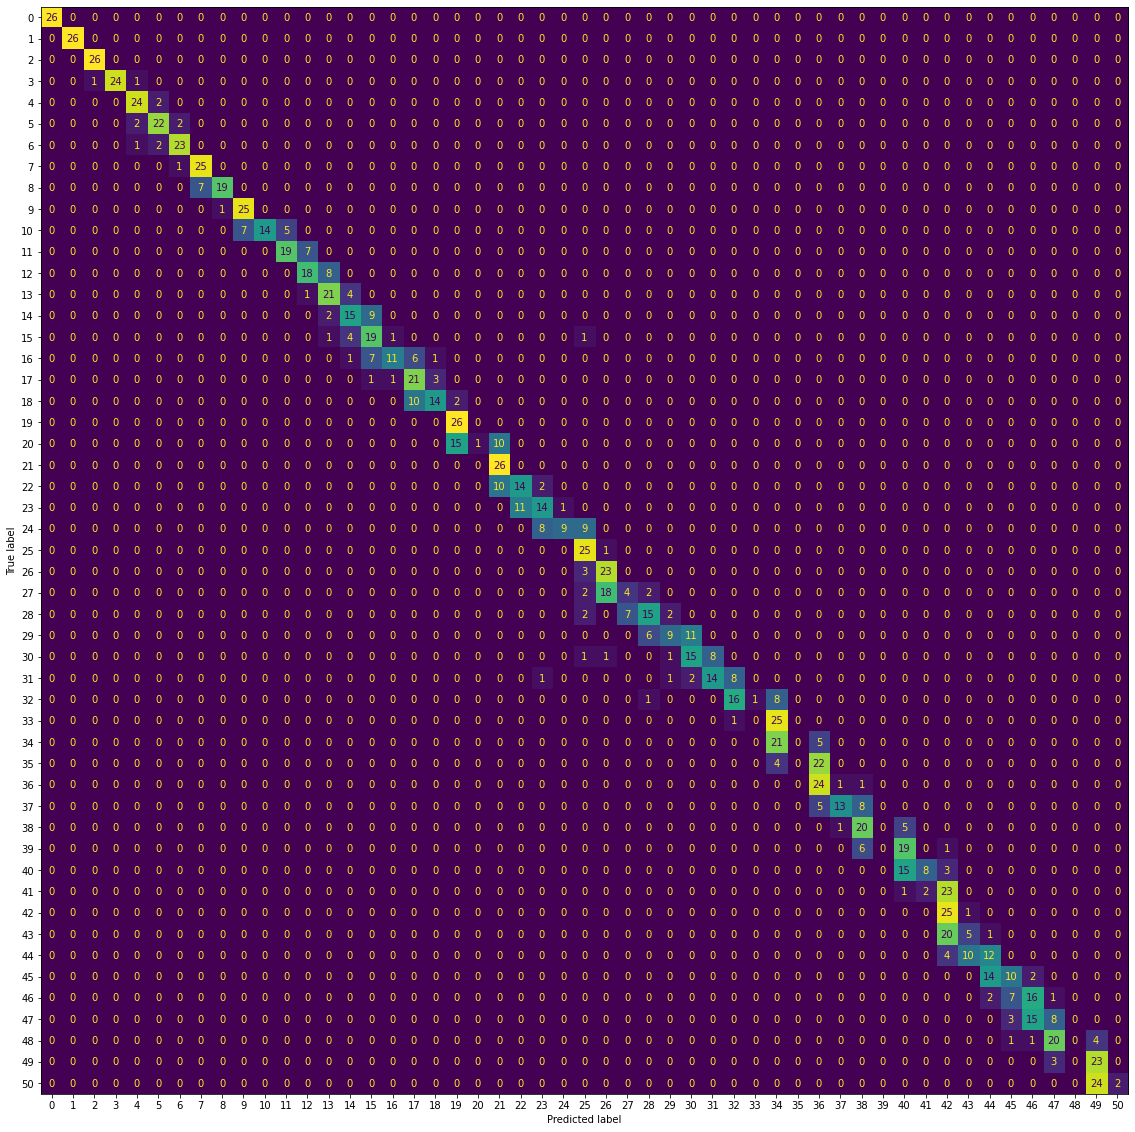

testing on c_sectorNN/test.json dataset
0.0%|7.5%|15.1%|22.6%|30.2%|37.7%|45.2%|52.8%|60.3%|67.9%|75.4%|83.0%|90.5%|98.0%|
Precisão: 0.5558069381598794
Erro Percentual Médio Absoluto: 2.5%


<Figure size 1440x1440 with 0 Axes>

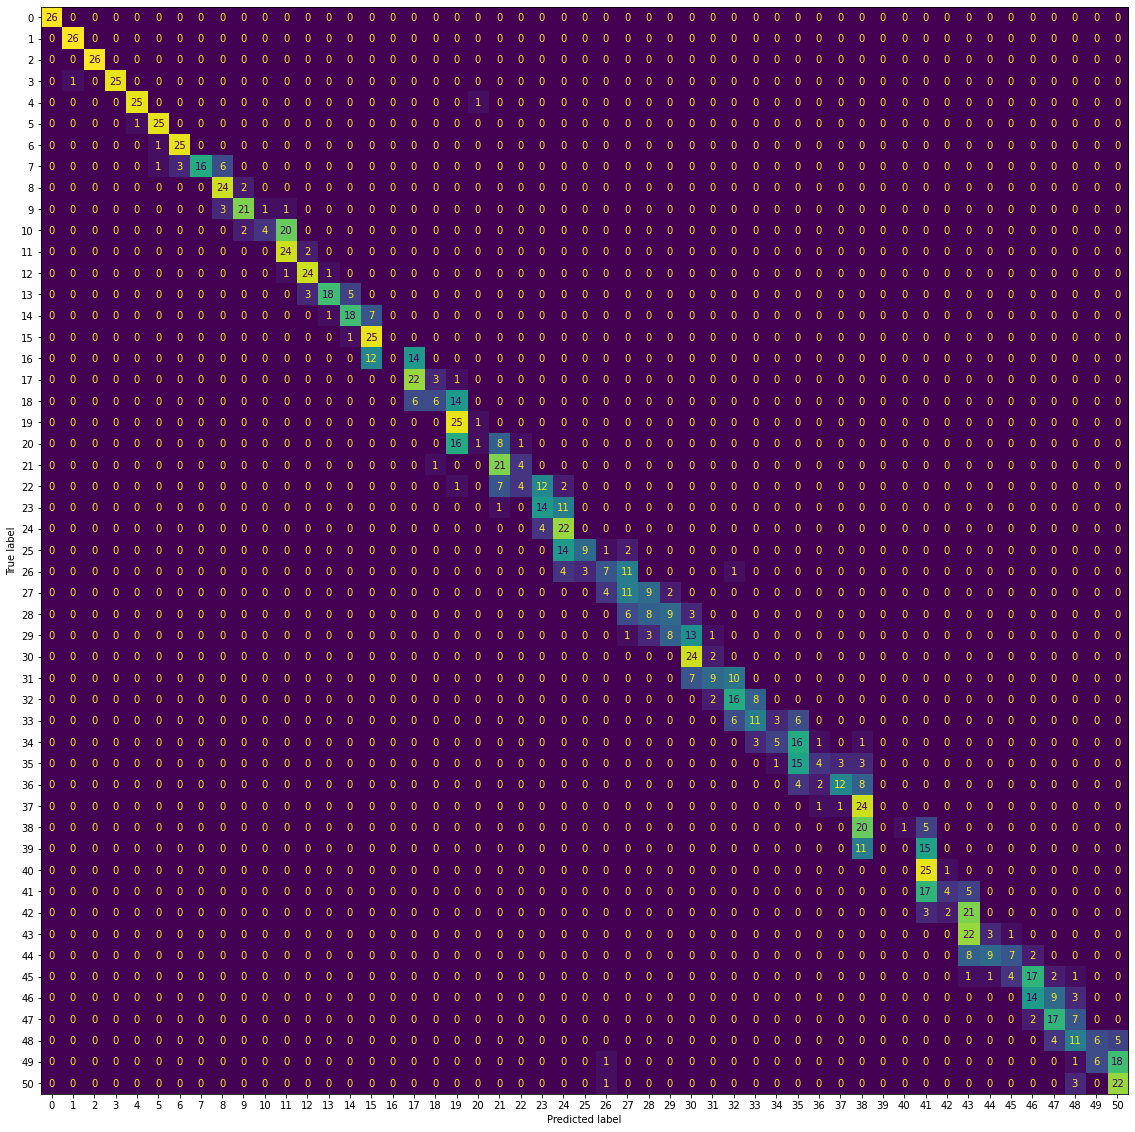

In [8]:
normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0, 1.0])

#data transforms incluem as futuras 'data augumentations' que serão usadas
#são utilizados para compor o handler de datasets
model_transform=transforms.Compose([transforms.Resize((256,256)),normalize])

#aplicando essas redes no dataset de teste
for index, row in df_results.iterrows():
    xykeys=row['objecto']+'NN/test.json'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    #cria um modelo densenet pre treinado
    model=models.densenet169().to(device)
    model.features.conv0=nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
    model.classifier=nn.Linear(in_features=1664, out_features=51, bias=True).to(device)
    
    model.load_state_dict(torch.load(row['NetFile']))
    
    TestModel(model,xykeys,row['val_list'],row['key_list'],row['objecto'])
    
    del model, device
    torch.cuda.empty_cache()
    


## Bastidores

In [1]:
!nvidia-smi

Mon Dec 12 00:46:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8    24W / 350W |   2097MiB / 12050MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------